# CA684 Machine Learning Assignment Spring 2024

Dublin City University has teamed up with **Etsy** to create the 2024 CA684 Machine Learning assignment.

## Etsy.com

Etsy is the global marketplace for unique and creative goods. It’s home to a universe of special, extraordinary items, from unique handcrafted pieces to vintage treasures. Etsy operates two-sided online marketplaces that collectively connect nearly 100 million passionate and creative buyers and 7.7 million sellers around the world.

Buyers come to the Etsy marketplace for meaningful, one-of-a-kind items handcrafted and curated with passion and expertise by our creative entrepreneurs. We are focused on attracting potential buyers to Etsy for everyday items that have meaning and those “special” purchase occasions that happen throughout the year. These include items that reflect an individual’s unique style; gifting that demonstrates thought and care; and celebrations that express creativity and fun.

On Etsy, someone searches for …
- Wall art every two seconds
- Wedding-related items every two seconds
- Gift-related items every second
- Antique or vintage items every half a second

## Challenge

Etsy has nearly 100 Million active listings on the etsy.com marketplace for sale from more than 5 million active sellers. You are provided a subset of those products as the training data.

The task is to leverage the training dataset to learn patterns from and to predict the following attributes on an unseen test dataset given a products’ information:

- top category id
- bottom category id

The goal is to maximize F1 for each of the classes on each attribute to predict (top category, bottom category). Your approaches and models will be benchmarked against a hidden test dataset.

Bonus points will be given for submissions that:

- visualize some learned representations or embeddings and show that similar items cluster together
- compares the performance of pre-trained embeddings taken from hubs or papers with a fine-tuned model


## Getting Started

Here is some sample code to get you started on the challenge!

Happy Hacking!

In [45]:
import io
import os
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn import metrics

font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)


In [56]:
import os
import re
import html
import gzip
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import clone
from sentence_transformers import SentenceTransformer
import tensorflow_hub as hub
import tensorflow as tf
from tqdm import tqdm
import joblib

In [58]:
np.random.seed(seed=42)

### Dataset

The train and test datasets are shared in **parquet** format.

In order to download the dataset, please sign the NDA first.

In [ ]:
from pathlib import Path

# Use Path to construct the full directory path safely
BASE_PATH = Path("/Users/chandanadaggupati/Downloads/data_2025/2025")

TRAIN_PATH = BASE_PATH / "train"
TEST_PATH = BASE_PATH / "test"

# Check if the paths exist
print("Train Path Exists:", TRAIN_PATH.exists())
print("Test Path Exists:", TEST_PATH.exists())


In [78]:
from pathlib import Path


BASE_PATH = Path("/Users/sandyajaleshkumar/Desktop/Machine Learning/Assignment/Dataset/2025")

TRAIN_PATH = BASE_PATH / "train"
TEST_PATH = BASE_PATH / "test"


print("Train Path Exists:", TRAIN_PATH.exists())
print("Test Path Exists:", TEST_PATH.exists())


Train Path Exists: True
Test Path Exists: True


In [ ]:

parquet_filenames_train = list(TRAIN_PATH.glob("*.parquet"))
print("Number of train files:", len(parquet_filenames_train))
print("Sample train files:", parquet_filenames_train[:3])

In [80]:

parquet_filenames_train = list(TRAIN_PATH.glob("*.parquet"))
print("Number of train files:", len(parquet_filenames_train))
print("Sample train files:", parquet_filenames_train[:3])


Number of train files: 362
Sample train files: [PosixPath('/Users/sandyajaleshkumar/Desktop/Machine Learning/Assignment/Dataset/2025/train/part-00296-of-00362.parquet.parquet'), PosixPath('/Users/sandyajaleshkumar/Desktop/Machine Learning/Assignment/Dataset/2025/train/part-00317-of-00362.parquet.parquet'), PosixPath('/Users/sandyajaleshkumar/Desktop/Machine Learning/Assignment/Dataset/2025/train/part-00320-of-00362.parquet.parquet')]


In [82]:
parquet_filenames_test = list(TEST_PATH.glob("*.parquet"))
print("Number of test files:", len(parquet_filenames_test))


Number of test files: 362


In [84]:
parquet_filenames_test[:3]

[PosixPath('/Users/sandyajaleshkumar/Desktop/Machine Learning/Assignment/Dataset/2025/test/part-00296-of-00362.parquet.parquet'),
 PosixPath('/Users/sandyajaleshkumar/Desktop/Machine Learning/Assignment/Dataset/2025/test/part-00317-of-00362.parquet.parquet'),
 PosixPath('/Users/sandyajaleshkumar/Desktop/Machine Learning/Assignment/Dataset/2025/test/part-00320-of-00362.parquet.parquet')]

In [86]:
f"Number of files in test: {len(parquet_filenames_test):,}"

'Number of files in test: 362'

### Exploratory Data Analysis

It is important to familiarize yourself with the dataset by using measures of centrality (e.g. mean) and statistical dispersion (e.g. variance) and data visualization methods. The following is just some Pandas preprocessing and Matplotlib visualizations to get you started. Feel free to explore the data much further and come up with ideas that might help you in the task!

### Training Dataset

This dataset can be used to train models and learn patterns from.

In [89]:
from pathlib import Path
import pandas as pd


PATH = Path("/Users/sandyajaleshkumar/Desktop/Machine Learning/Assignment/Dataset/2025")


def read_data(folder, filenames):
    """ Read parquet data from multiple files """
    folder_path = PATH / folder
    dataframes = [
        pd.read_parquet(folder_path / filename)
        for filename in filenames
    ]
    return pd.concat(dataframes)


df_train = read_data("train", parquet_filenames_train)


In [91]:
f"Number of rows in train: {len(df_train):,}"

'Number of rows in train: 229,624'

In [93]:
f"Number of unique products in train: {len(df_train['product_id'].unique()):,}"

'Number of unique products in train: 229,624'

In [95]:
f"Number of columns in train: {len(df_train.columns):,}"

'Number of columns in train: 23'

In [97]:
list(df_train.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern',
 'bottom_category_id',
 'bottom_category_text',
 'top_category_id',
 'top_category_text',
 'primary_color_id',
 'primary_color_text',
 'secondary_color_id',
 'secondary_color_text']

In [99]:
df_train.iloc[0]

product_id                                                      509903859
title                           Sweet Lies Flower Power Silver Golf Shirt
description             This silver polo shirt screams late nineties, ...
tags                    gothic,clubkid,club,rave,flower power,butterfl...
type                                                             physical
room                                                                     
craft_type                                                               
recipient                                                                
material                                                                 
occasion                                                                 
holiday                                                                  
art_subject                                                              
style                                                                    
shape                                 

In [101]:
df_train.head(2)

product_id                                              title  \
0   509903859          Sweet Lies Flower Power Silver Golf Shirt   
1  1311017577  Women&#39;s Vintage 80s Lacoste Izod Blue Whit...   

                                         description  \
0  This silver polo shirt screams late nineties, ...   
1  Selling a Women&#39;s Vintage 80s Lacoste Izod...   

                                                tags      type room  \
0  gothic,clubkid,club,rave,flower power,butterfl...  physical        
1  izod,lacoste,womens,ladies,made in usa,vintage...  physical        

  craft_type recipient material occasion  ... shape  pattern  \
0                                         ...                  
1                                         ...        striped   

  bottom_category_id                          bottom_category_text  \
0                557  clothing.womens_clothing.tops_and_tees.polos   
1                557  clothing.womens_clothing.tops_and_tees.polos   

  top_category_id  top_category_text primary_color_id  primary_color_text  \
0               5           clothing               16              silver   
1               5           clothing                2                blue   

  secondary_color_id  secondary_color_text  
0                  1                 black  
1                 17                 white  

[2 rows x 23 columns]

In [103]:
df_train['type'].unique()

array(['physical', 'download', ''], dtype=object)

In [105]:
df_train['type'].value_counts(dropna=False)

type
physical    218568
download     10708
               348
Name: count, dtype: int64

In [107]:
f"Number of top categories in train: {len(df_train['top_category_text'].unique()):,}"

'Number of top categories in train: 15'

In [109]:
pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)

/var/folders/x0/50_cl34x1zg9wnnjkygh0svc0000gn/T/ipykernel_52153/1076920215.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)


top_category_text
home_and_living                54600
craft_supplies_and_tools       33393
clothing                       30143
toys_and_games                 13835
accessories                    12416
paper_and_party_supplies       12207
bath_and_beauty                11327
weddings                       10143
shoes                           8892
art_and_collectibles            8716
jewelry                         7822
electronics_and_accessories     7474
bags_and_purses                 6650
books_movies_and_music          6262
pet_supplies                    5744
Name: count, dtype: int64

/var/folders/x0/50_cl34x1zg9wnnjkygh0svc0000gn/T/ipykernel_52153/1474438048.py:8: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(


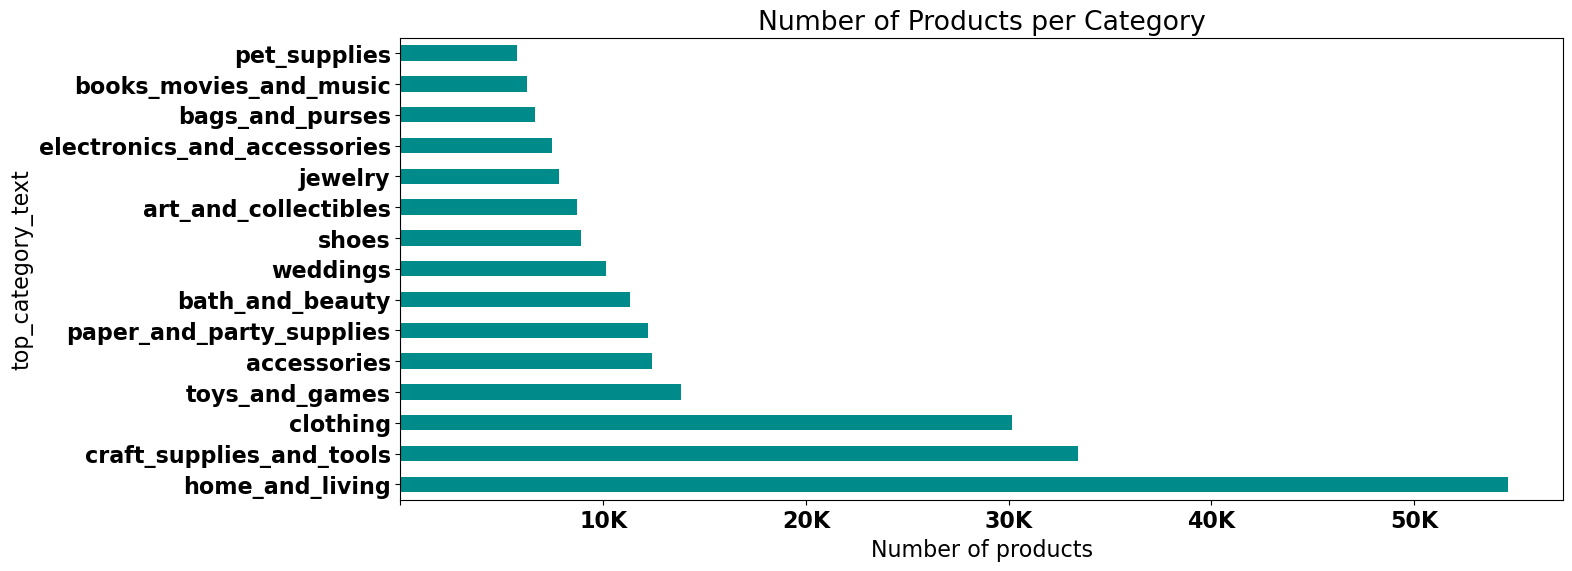

In [111]:
figsize = (15, 6)
column = 'top_category_text'
x_limit = 60000
x_step = 10000
color = 'darkcyan'

figure, ax = plt.subplots(figsize=figsize)
pd.value_counts(
    df_train[column],
    sort=True, ascending=False).plot.barh(color=color)
plt.title(f"Number of Products per Category")
xlabels = [f'{x // 1000:,}K' for x in range(0, x_limit, x_step)]
plt.xticks(range(0, x_limit, x_step), xlabels)
plt.xlabel('Number of products')
plt.setp(ax.get_xticklabels()[0], visible=False)
plt.show()

In [112]:
f"Number of bottom categories in train: {len(df_train['bottom_category_text'].unique()):,}"

'Number of bottom categories in train: 2,609'

In [115]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229624 entries, 0 to 74
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   product_id            229624 non-null  int64 
 1   title                 229624 non-null  object
 2   description           229624 non-null  object
 3   tags                  229624 non-null  object
 4   type                  229624 non-null  object
 5   room                  229624 non-null  object
 6   craft_type            229624 non-null  object
 7   recipient             229624 non-null  object
 8   material              229624 non-null  object
 9   occasion              229624 non-null  object
 10  holiday               229624 non-null  object
 11  art_subject           229624 non-null  object
 12  style                 229624 non-null  object
 13  shape                 229624 non-null  object
 14  pattern               229624 non-null  object
 15  bottom_category_id    2296

In [117]:
df_train.isnull().sum().sort_values(ascending=False)


product_id              0
style                   0
secondary_color_id      0
primary_color_text      0
primary_color_id        0
top_category_text       0
top_category_id         0
bottom_category_text    0
bottom_category_id      0
pattern                 0
shape                   0
art_subject             0
title                   0
holiday                 0
occasion                0
material                0
recipient               0
craft_type              0
room                    0
type                    0
tags                    0
description             0
secondary_color_text    0
dtype: int64

In [119]:
missing = df_train.isnull().sum()
missing[missing > 0].sort_values(ascending=False)


Series([], dtype: int64)

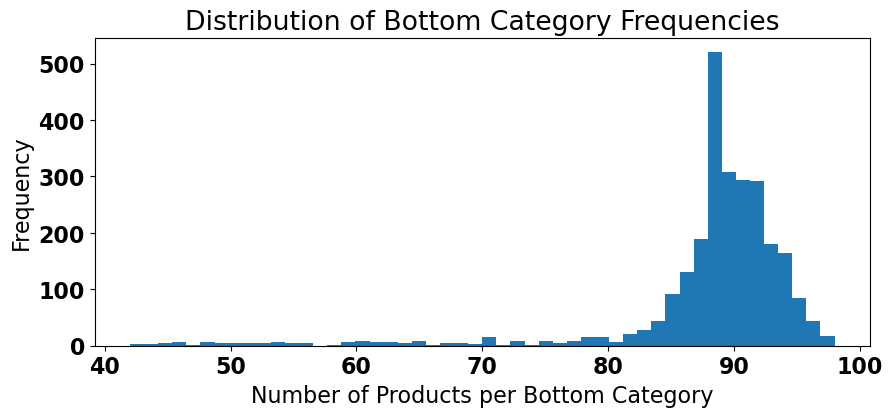

In [121]:
# Histogram of how often each bottom_category_id appears
df_train['bottom_category_id'].value_counts().plot.hist(
    bins=50,
    figsize=(10, 4),
    title="Distribution of Bottom Category Frequencies"
)
plt.xlabel("Number of Products per Bottom Category")
plt.show()


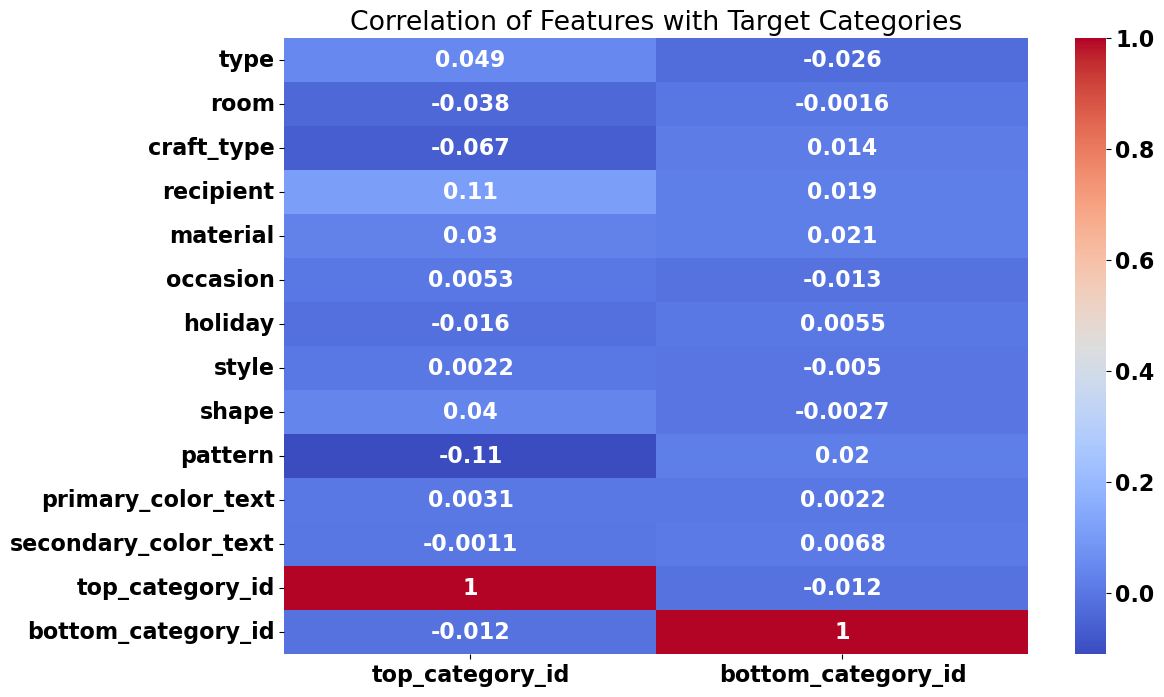

In [123]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


cols_to_check = [
    'type', 'room', 'craft_type', 'recipient', 'material', 'occasion', 'holiday',
    'style', 'shape', 'pattern', 'primary_color_text', 'secondary_color_text',
    'top_category_id', 'bottom_category_id'
]


encoded_df = df_train[cols_to_check].apply(lambda x: pd.factorize(x)[0])


correlation_matrix = encoded_df.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['top_category_id', 'bottom_category_id']], annot=True, cmap='coolwarm')
plt.title("Correlation of Features with Target Categories")
plt.show()


### Test Dataset

The test dataset will be used to predict using the model/s you have trained

**Note** that categories and colors for the test data are hidden, you have to predict them!

In [126]:
df_test = read_data("test", parquet_filenames_test)

In [127]:
f'Number of rows in test: {len(df_test):,}'

'Number of rows in test: 25,514'

In [130]:
f"Number of unique products in test: {len(df_test['product_id'].unique()):,}"

'Number of unique products in test: 25,514'

In [132]:
f"Number of columns in test: {len(df_test.columns):,}"

'Number of columns in test: 15'

In [134]:
list(df_test.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern']

In [136]:
df_test.iloc[0]

product_id                                             853043770
title          Covered Up! Vintage Hand Embroidered Baby Crib...
description    Covered Up! Vintage Hand Embroidered Baby Crib...
tags           Baby crib topper,cotton crib sheet,topper shee...
type                                                    physical
room                                                            
craft_type                                                      
recipient                                                 babies
material                                                  cotton
occasion                                             baby shower
holiday                                                         
art_subject                                                     
style                                                           
shape                                                           
pattern                                                 bordered
Name: 0, dtype: object

### Model Training

Let's first split the data to be able to evaluate our model against a validation dataset. This validation set can also be used to fine tune your model before making the predictions on the hidden test set.

In [139]:
from sklearn.model_selection import train_test_split

df_training, df_validation = train_test_split(
    df_train,
    test_size=0.1,
    stratify=df_train['bottom_category_text'],
    random_state=42)

In [141]:
f"Number of products for training: {len(df_training):,}"

'Number of products for training: 206,661'

In [143]:
f"Number of products for validation: {len(df_validation):,}"

'Number of products for validation: 22,963'

In [145]:
df_training['bottom_category_text'].value_counts()

bottom_category_text
jewelry.earrings.dangle_earrings.chandbalis                                         88
accessories.scarves_and_wraps.scarves                                               88
home_and_living.kitchen_and_dining.dining_and_serving.cake_stands                   88
craft_supplies_and_tools.closures_and_fasteners.buttons                             88
art_and_collectibles.drawing_and_illustration.architectural_drawings                88
                                                                                    ..
weddings.clothing.jumpsuits_and_rompers                                             40
clothing.girls_clothing.baby_girls_clothing.socks_and_leg_warmers                   40
home_and_living.lighting.light_accessories                                          39
clothing.womens_clothing.pajamas_and_robes.sleep_masks_and_blindfolds.blindfolds    38
craft_supplies_and_tools.doll_and_model_supplies.noise_makers                       38
Name: count, Length: 2

In [147]:
df_validation['bottom_category_text'].value_counts()

bottom_category_text
clothing.girls_clothing.underwear.panties                                                                             10
craft_supplies_and_tools.paints_inks_and_dyes.paint.chalk_paint                                                       10
clothing.girls_clothing.baby_girls_clothing.sweaters                                                                  10
craft_supplies_and_tools.storage_and_organization.containers.bottles_cans_and_jars.lids_rings_and_caps.bottle_caps    10
paper_and_party_supplies.party_supplies.party_decor.party_candles                                                     10
                                                                                                                      ..
home_and_living.furniture.entryway_furniture.standing_coat_racks                                                       4
jewelry.earrings.kaan_chains                                                                                           4
craft_suppl

In [149]:
df_training['top_category_text'].value_counts()

top_category_text
home_and_living                49140
craft_supplies_and_tools       30056
clothing                       27139
toys_and_games                 12448
accessories                    11173
paper_and_party_supplies       10984
bath_and_beauty                10187
weddings                        9128
shoes                           8001
art_and_collectibles            7846
jewelry                         7040
electronics_and_accessories     6727
bags_and_purses                 5986
books_movies_and_music          5636
pet_supplies                    5170
Name: count, dtype: int64

In [151]:
df_validation['top_category_text'].value_counts()

top_category_text
home_and_living                5460
craft_supplies_and_tools       3337
clothing                       3004
toys_and_games                 1387
accessories                    1243
paper_and_party_supplies       1223
bath_and_beauty                1140
weddings                       1015
shoes                           891
art_and_collectibles            870
jewelry                         782
electronics_and_accessories     747
bags_and_purses                 664
books_movies_and_music          626
pet_supplies                    574
Name: count, dtype: int64

In [153]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25514 entries, 0 to 12
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   product_id   25514 non-null  int64 
 1   title        25514 non-null  object
 2   description  25514 non-null  object
 3   tags         25514 non-null  object
 4   type         25514 non-null  object
 5   room         25514 non-null  object
 6   craft_type   25514 non-null  object
 7   recipient    25514 non-null  object
 8   material     25514 non-null  object
 9   occasion     25514 non-null  object
 10  holiday      25514 non-null  object
 11  art_subject  25514 non-null  object
 12  style        25514 non-null  object
 13  shape        25514 non-null  object
 14  pattern      25514 non-null  object
dtypes: int64(1), object(14)
memory usage: 3.1+ MB


In [155]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229624 entries, 0 to 74
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   product_id            229624 non-null  int64 
 1   title                 229624 non-null  object
 2   description           229624 non-null  object
 3   tags                  229624 non-null  object
 4   type                  229624 non-null  object
 5   room                  229624 non-null  object
 6   craft_type            229624 non-null  object
 7   recipient             229624 non-null  object
 8   material              229624 non-null  object
 9   occasion              229624 non-null  object
 10  holiday               229624 non-null  object
 11  art_subject           229624 non-null  object
 12  style                 229624 non-null  object
 13  shape                 229624 non-null  object
 14  pattern               229624 non-null  object
 15  bottom_category_id    2296

### Data Denoising 

In [158]:
def clean_text(text):
    if pd.isna(text): return ""
    text = html.unescape(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def combine_text(df):
    return (
        df["title"].fillna("") + " " +
        df["description"].fillna("") + " " +
        df["tags"].fillna("")
    ).apply(clean_text)

## Training - Bottom Category

### LinearSVC + TFIDF (vocab size = 20000) -> model's prediction is based on this

In [139]:

df_training["text"] = combine_and_clean(df_training)
df_validation["text"] = combine_and_clean(df_validation)


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training["bottom_category_text"])
y_val = label_encoder.transform(df_validation["bottom_category_text"])


vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 3),
    stop_words='english'
)
X_train = vectorizer.fit_transform(df_training["text"])
X_val = vectorizer.transform(df_validation["text"])


svc = LinearSVC(C=0.5, dual=False, class_weight='balanced', max_iter=1500)
svc.fit(X_train, y_train)


y_pred = svc.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)


f1


C:\Users\asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.6210373020565739

In [141]:
report

'                                                                                                                        precision    recall  f1-score   support\n\n                                                                                                           accessories       0.00      0.00      0.00         9\n                                                                                          accessories.baby_accessories       0.50      0.33      0.40         9\n                                                                  accessories.baby_accessories.baby_carriers_and_wraps       0.83      0.56      0.67         9\n                                                                    accessories.baby_accessories.childrens_photo_props       0.50      0.56      0.53         9\n                                                                                      accessories.belts_and_suspenders       1.00      0.30      0.46        10\n                               

In [143]:
import joblib

# Save each component to disk
joblib.dump(svc, "bottom_svc_model.pkl")
joblib.dump(vectorizer, "bottom_tfidf_vectorizer.pkl")
joblib.dump(label_encoder, "bottom_label_encoder.pkl")


['bottom_label_encoder.pkl']

#### Predictions on the test for the bottom category

In [134]:
import pandas as pd
import re, html
import joblib
import os

# Step 1: Load saved components
model = joblib.load("bottom_svc_model.pkl")
vectorizer = joblib.load("bottom_tfidf_vectorizer.pkl")
label_encoder = joblib.load("bottom_label_encoder.pkl")


# Step 3: Clean and combine text
def clean_text(text):
    if pd.isna(text): return ""
    text = html.unescape(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return re.sub(r"\s+", " ", text).strip()

def combine_text(df):
    return (
        df["title"].fillna("") + " " +
        df["description"].fillna("") + " " +
        df["tags"].fillna("")
    ).apply(clean_text)

df_test["text"] = combine_text(df_test)

# Step 4: TF-IDF transform and prediction
X_test = vectorizer.transform(df_test["text"])
y_pred = model.predict(X_test)

# Step 5: Save predicted bottom_category_id
df_test["predicted_bottom_category_id"] = y_pred
df_test[["product_id", "predicted_bottom_category_id"]].to_csv("bottom_category_predictions.csv", index=False)

print("Predictions saved to: bottom_category_predictions.csv")
print(f"Location: {os.getcwd()}/bottom_category_predictions.csv")


Predictions saved to: bottom_category_predictions.csv
Location: C:\Users\asus/bottom_category_predictions.csv


### LinearSVC + TF-IDF (vocab size = 8000)

In [133]:


df_training["text"] = combine_and_clean(df_training)
df_validation["text"] = combine_and_clean(df_validation)


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training["bottom_category_text"])
y_val = label_encoder.transform(df_validation["bottom_category_text"])


vectorizer = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 3),
    stop_words='english'
)
X_train = vectorizer.fit_transform(df_training["text"])
X_val = vectorizer.transform(df_validation["text"])


svc = LinearSVC(C=0.5, dual=False, class_weight='balanced', max_iter=1500)
svc.fit(X_train, y_train)


y_pred = svc.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)


f1


C:\Users\asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.6018032942050555

In [135]:
report 

'                                                                                                                        precision    recall  f1-score   support\n\n                                                                                                           accessories       0.00      0.00      0.00         9\n                                                                                          accessories.baby_accessories       0.75      0.33      0.46         9\n                                                                  accessories.baby_accessories.baby_carriers_and_wraps       0.80      0.44      0.57         9\n                                                                    accessories.baby_accessories.childrens_photo_props       0.56      0.56      0.56         9\n                                                                                      accessories.belts_and_suspenders       1.00      0.30      0.46        10\n                               

In [137]:
import joblib

# Save each component to disk
joblib.dump(svc, "bottom_svc_model.pkl")
joblib.dump(vectorizer, "bottom_tfidf_vectorizer.pkl")
joblib.dump(label_encoder, "bottom_label_encoder.pkl")


['bottom_label_encoder.pkl']

###  LinearSVC + TF-IDF (vocab size = 5000)

In [188]:


df_training["text"] = combine_and_clean(df_training)
df_validation["text"] = combine_and_clean(df_validation)


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training["bottom_category_text"])
y_val = label_encoder.transform(df_validation["bottom_category_text"])


vocab_size = 5000  
vectorizer = TfidfVectorizer(max_features=vocab_size, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(df_training["text"])
X_val = vectorizer.transform(df_validation["text"])


svc = LinearSVC(max_iter=1000)
svc.fit(X_train, y_train)


y_pred = svc.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)

f1


C:\Users\asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.573737167520084

In [190]:
import joblib
# Save the classifier
joblib.dump(svc, "bottom_svc_model.pkl")
# Save the vectorizer
joblib.dump(vectorizer, "bottom_tfidf_vectorizer.pkl")
# Save the label encoder
joblib.dump(label_encoder, "bottom_label_encoder.pkl")


['bottom_label_encoder.pkl']

### TF-IDF + TruncatedSVD (dimensionality reduction) + LogisticRegression


In [93]:


df_training["text"] = combine_and_clean(df_training)
df_validation["text"] = combine_and_clean(df_validation)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training["bottom_category_text"])
y_val = label_encoder.transform(df_validation["bottom_category_text"])


vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(df_training["text"])
X_val_tfidf = vectorizer.transform(df_validation["text"])


svd = TruncatedSVD(n_components=300, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd = svd.transform(X_val_tfidf)


clf = LogisticRegression(max_iter=300, class_weight="balanced", solver="saga", random_state=42)
clf.fit(X_train_svd, y_train)


y_pred = clf.predict(X_val_svd)
f1 = f1_score(y_val, y_pred, average="weighted")
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)

f1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ModuleNotFoundError: No module named 'ace_tools'

In [101]:
from sklearn.metrics import f1_score

# Display only the overall (weighted) F1 score
f1_only = f1_score(y_val, y_pred, average='weighted')
f1_only


0.34036319138150445

### MLP + Glove

In [94]:

glove_path = "/Users/sandyajaleshkumar/Desktop/Machine Learning/Assignment/glove.6B/glove.6B.100d.txt"


def load_glove_embeddings(filepath):
    embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove = load_glove_embeddings(glove_path)
embedding_dim = 100


df_training['text'] = combine_and_clean(df_training)
df_validation['text'] = combine_and_clean(df_validation)


def text_to_glove_vector(text, glove, dim):
    words = text.split()
    vectors = [glove[word] for word in words if word in glove]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

X_train_glove = np.vstack([text_to_glove_vector(t, glove, embedding_dim) for t in df_training['text']])
X_val_glove = np.vstack([text_to_glove_vector(t, glove, embedding_dim) for t in df_validation['text']])

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training['bottom_category_text'])
y_val = label_encoder.transform(df_validation['bottom_category_text'])


mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300, random_state=42)
mlp.fit(X_train_glove, y_train)


y_pred = mlp.predict(X_val_glove)
f1 = f1_score(y_val, y_pred, average='weighted')
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)

f1, report


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill

(0.39839399581999835,
 '                                                                                                                        precision    recall  f1-score   support\n\n                                                                                                           accessories       0.00      0.00      0.00         9\n                                                                                          accessories.baby_accessories       0.33      0.11      0.17         9\n                                                                  accessories.baby_accessories.baby_carriers_and_wraps       0.40      0.22      0.29         9\n                                                                    accessories.baby_accessories.childrens_photo_props       0.00      0.00      0.00         9\n                                                                                      accessories.belts_and_suspenders       0.18      0.20      0.19        10\n        

### MiniLM Embeddings + SGDClassifier with Incremental Training

In [583]:

embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training['bottom_category_text'])
y_val = label_encoder.transform(df_validation['bottom_category_text'])


X_train_embed = embedder.encode(df_training['text'].tolist(), show_progress_bar=True)
X_val_embed = embedder.encode(df_validation['text'].tolist(), show_progress_bar=True)


clf = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42)
classes = np.unique(y_train)


n_batches = 5
batch_size = len(X_train_embed) // n_batches

for i in range(n_batches):
    start = i * batch_size
    end = (i + 1) * batch_size if i < n_batches - 1 else len(X_train_embed)
    X_batch = X_train_embed[start:end]
    y_batch = y_train[start:end]
    clf.partial_fit(X_batch, y_batch, classes=classes if i == 0 else None)

y_pred = clf.predict(X_val_embed)
f1 = f1_score(y_val, y_pred, average='weighted')
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)

f1, report


Batches:   0%|          | 0/6459 [00:00<?, ?it/s]

Batches:   0%|          | 0/718 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.24744893299953136,
 '                                                                                                                        precision    recall  f1-score   support\n\n                                                                                                           accessories       0.00      0.00      0.00         9\n                                                                                          accessories.baby_accessories       0.00      0.00      0.00         9\n                                                                  accessories.baby_accessories.baby_carriers_and_wraps       1.00      0.22      0.36         9\n                                                                    accessories.baby_accessories.childrens_photo_props       0.00      0.00      0.00         9\n                                                                                      accessories.belts_and_suspenders       0.00      0.00      0.00        10\n        

### MiniLM + Categorical Hybrid MLP with Safe Oversampling for Bottom Category Classification

In [577]:

df_training['text'] = combine_and_clean(df_training)
df_validation['text'] = combine_and_clean(df_validation)


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training['bottom_category_text'])
y_val = label_encoder.transform(df_validation['bottom_category_text'])


embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
X_train_embed = embedder.encode(df_training['text'].tolist(), show_progress_bar=True)
X_val_embed = embedder.encode(df_validation['text'].tolist(), show_progress_bar=True)


categorical_cols = [
    'type', 'room', 'craft_type', 'recipient', 'material',
    'occasion', 'holiday'
]
for col in categorical_cols:
    df_training[col] = df_training[col].fillna('unknown')
    df_validation[col] = df_validation[col].fillna('unknown')

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = ohe.fit_transform(df_training[categorical_cols])
X_val_cat = ohe.transform(df_validation[categorical_cols])

X_train_hybrid = np.hstack([X_train_embed, X_train_cat])
X_val_hybrid = np.hstack([X_val_embed, X_val_cat])

# Safe oversampling
df_train_hybrid = pd.DataFrame(X_train_hybrid)
df_train_hybrid['label'] = y_train
class_counts = df_train_hybrid['label'].value_counts()
mean_count = class_counts.mean()

df_upsampled = []
for cls, count in class_counts.items():
    df_class = df_train_hybrid[df_train_hybrid['label'] == cls]
    if count < mean_count:
        upsampled = resample(
            df_class,
            replace=True,
            n_samples=min(int(count * 2), int(mean_count)),
            random_state=42
        )
        df_upsampled.append(upsampled)
    else:
        df_upsampled.append(df_class)


df_balanced = pd.concat(df_upsampled)
X_balanced = df_balanced.drop(columns=['label']).values
y_balanced = df_balanced['label'].values


mlp_oversampled = MLPClassifier(
    hidden_layer_sizes=(768, 256),
    activation='relu',
    alpha=1e-4,
    max_iter=300,
    random_state=42
)
mlp_oversampled.fit(X_balanced, y_balanced)


y_pred_os = mlp_oversampled.predict(X_val_hybrid)
f1_os = f1_score(y_val, y_pred_os, average='weighted')
report_os = classification_report(y_val, y_pred_os, target_names=label_encoder.classes_)

f1_os, report_os


Batches:   0%|          | 0/6459 [00:00<?, ?it/s]

Batches:   0%|          | 0/718 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.5186589660358952,
 '                                                                                                                        precision    recall  f1-score   support\n\n                                                                                                           accessories       0.08      0.11      0.09         9\n                                                                                          accessories.baby_accessories       0.38      0.33      0.35         9\n                                                                  accessories.baby_accessories.baby_carriers_and_wraps       0.31      0.56      0.40         9\n                                                                    accessories.baby_accessories.childrens_photo_props       0.15      0.22      0.18         9\n                                                                                      accessories.belts_and_suspenders       0.29      0.40      0.33        10\n         

### MiniLM + Categorical Hybrid MLP

In [289]:

df_training['text'] = combine_and_clean(df_training)
df_validation['text'] = combine_and_clean(df_validation)


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training['bottom_category_text'])
y_val = label_encoder.transform(df_validation['bottom_category_text'])

embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
X_train_embed = embedder.encode(df_training['text'].tolist(), show_progress_bar=True)
X_val_embed = embedder.encode(df_validation['text'].tolist(), show_progress_bar=True)


categorical_cols = [
    'type', 'room', 'craft_type', 'recipient', 'material',
    'occasion', 'holiday'
]
for col in categorical_cols:
    df_training[col] = df_training[col].fillna('unknown')
    df_validation[col] = df_validation[col].fillna('unknown')

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = ohe.fit_transform(df_training[categorical_cols])
X_val_cat = ohe.transform(df_validation[categorical_cols])

X_train_hybrid = np.hstack([X_train_embed, X_train_cat])
X_val_hybrid = np.hstack([X_val_embed, X_val_cat])

tuned_mlp = MLPClassifier(
    hidden_layer_sizes=(768, 256),
    activation='relu',
    alpha=1e-4,
    max_iter=300,
    random_state=42
)


tuned_mlp.fit(X_train_hybrid, y_train)
y_pred_tuned = tuned_mlp.predict(X_val_hybrid)
f1_tuned = f1_score(y_val, y_pred_tuned, average='weighted')
report_tuned = classification_report(y_val, y_pred_tuned, target_names=label_encoder.classes_)

f1_tuned, report_tuned


Batches:   0%|          | 0/6459 [00:00<?, ?it/s]

Batches:   0%|          | 0/718 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.53359511945113,
 '                                                                                                                        precision    recall  f1-score   support\n\n                                                                                                           accessories       0.00      0.00      0.00         9\n                                                                                          accessories.baby_accessories       0.25      0.11      0.15         9\n                                                                  accessories.baby_accessories.baby_carriers_and_wraps       0.22      0.22      0.22         9\n                                                                    accessories.baby_accessories.childrens_photo_props       0.12      0.11      0.12         9\n                                                                                      accessories.belts_and_suspenders       0.25      0.20      0.22        10\n           

### MiniLM Sentence Embeddings with MLP Classifier

In [104]:

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training['bottom_category_text'])
y_val = label_encoder.transform(df_validation['bottom_category_text'])


embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
X_train_embed = embedder.encode(df_training['text'].tolist(), show_progress_bar=True)
X_val_embed = embedder.encode(df_validation['text'].tolist(), show_progress_bar=True)


mlp = MLPClassifier(hidden_layer_sizes=(512, 256), max_iter=300, random_state=42)
mlp.fit(X_train_embed, y_train)


y_pred_mlp = mlp.predict(X_val_embed)
f1_mlp = f1_score(y_val, y_pred_mlp, average='weighted')
report_mlp = classification_report(y_val, y_pred_mlp, target_names=label_encoder.classes_)

f1_mlp, report_mlp


Batches:   0%|          | 0/6459 [00:00<?, ?it/s]

Batches:   0%|          | 0/718 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

(0.4907757444571909,
 '                                                                                                                        precision    recall  f1-score   support\n\n                                                                                                           accessories       0.00      0.00      0.00         9\n                                                                                          accessories.baby_accessories       0.14      0.11      0.12         9\n                                                                  accessories.baby_accessories.baby_carriers_and_wraps       0.23      0.33      0.27         9\n                                                                    accessories.baby_accessories.childrens_photo_props       0.20      0.11      0.14         9\n                                                                                      accessories.belts_and_suspenders       0.67      0.40      0.50        10\n         

### MiniLM Embeddings Combined with One-Hot Encoded Categorical Features for Hybrid MLP Classification

In [285]:

categorical_cols = [
    'type', 'room', 'craft_type', 'recipient', 'material',
    'occasion', 'holiday'
]
for col in categorical_cols:
    df_training[col] = df_training[col].fillna('unknown')
    df_validation[col] = df_validation[col].fillna('unknown')


ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = ohe.fit_transform(df_training[categorical_cols])
X_val_cat = ohe.transform(df_validation[categorical_cols])


X_train_hybrid = np.hstack([X_train_embed, X_train_cat])
X_val_hybrid = np.hstack([X_val_embed, X_val_cat])


mlp_hybrid = MLPClassifier(hidden_layer_sizes=(512, 256), max_iter=300, random_state=42)
mlp_hybrid.fit(X_train_hybrid, y_train)


y_pred_hybrid = mlp_hybrid.predict(X_val_hybrid)
f1_hybrid = f1_score(y_val, y_pred_hybrid, average='weighted')
report_hybrid = classification_report(y_val, y_pred_hybrid, target_names=label_encoder.classes_)

f1_hybrid, report_hybrid


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

(0.5369511273799333,
 '                                                                                                                        precision    recall  f1-score   support\n\n                                                                                                           accessories       0.17      0.11      0.13         9\n                                                                                          accessories.baby_accessories       0.30      0.33      0.32         9\n                                                                  accessories.baby_accessories.baby_carriers_and_wraps       0.00      0.00      0.00         9\n                                                                    accessories.baby_accessories.childrens_photo_props       0.67      0.22      0.33         9\n                                                                                      accessories.belts_and_suspenders       0.42      0.50      0.45        10\n         

### MiniLM Embeddings with Incremental Training using SGDClassifier 

In [100]:

embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training['bottom_category_text'])
y_val = label_encoder.transform(df_validation['bottom_category_text'])


X_train_embed = embedder.encode(df_training['text'].tolist(), show_progress_bar=True)
X_val_embed = embedder.encode(df_validation['text'].tolist(), show_progress_bar=True)


clf = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42)
classes = np.unique(y_train)


n_batches = 5
batch_size = len(X_train_embed) // n_batches

for i in range(n_batches):
    start = i * batch_size
    end = (i + 1) * batch_size if i < n_batches - 1 else len(X_train_embed)
    X_batch = X_train_embed[start:end]
    y_batch = y_train[start:end]
    clf.partial_fit(X_batch, y_batch, classes=classes if i == 0 else None)


y_pred = clf.predict(X_val_embed)
f1 = f1_score(y_val, y_pred, average='weighted')
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)

f1, report


Batches:   0%|          | 0/6459 [00:00<?, ?it/s]

Batches:   0%|          | 0/718 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.24744893299953136,
 '                                                                                                                        precision    recall  f1-score   support\n\n                                                                                                           accessories       0.00      0.00      0.00         9\n                                                                                          accessories.baby_accessories       0.00      0.00      0.00         9\n                                                                  accessories.baby_accessories.baby_carriers_and_wraps       1.00      0.22      0.36         9\n                                                                    accessories.baby_accessories.childrens_photo_props       0.00      0.00      0.00         9\n                                                                                      accessories.belts_and_suspenders       0.00      0.00      0.00        10\n        

### TF-IDF and Categorical Feature Fusion with Balanced SGDClassifier 

In [98]:


df_training['text'] = combine_and_clean(df_training)
df_validation['text'] = combine_and_clean(df_validation)


categorical_cols = [
    'type', 'room', 'craft_type', 'recipient', 'material',
    'occasion', 'holiday'
]
for col in categorical_cols:
    df_training[col] = df_training[col].fillna('unknown')
    df_validation[col] = df_validation[col].fillna('unknown')


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training['bottom_category_text'])
y_val = label_encoder.transform(df_validation['bottom_category_text'])


text_col = 'text'
X_train = df_training[[text_col] + categorical_cols].copy()
X_val = df_validation[[text_col] + categorical_cols].copy()

preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2)), text_col),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
])


pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', SGDClassifier(loss='log_loss', max_iter=1000, class_weight='balanced', random_state=42))
])


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)

f1, report


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.24717139953067377,
 '                                                                                                                        precision    recall  f1-score   support\n\n                                                                                                           accessories       0.00      0.00      0.00         9\n                                                                                          accessories.baby_accessories       0.00      0.00      0.00         9\n                                                                  accessories.baby_accessories.baby_carriers_and_wraps       0.06      0.44      0.10         9\n                                                                    accessories.baby_accessories.childrens_photo_props       0.00      0.00      0.00         9\n                                                                                      accessories.belts_and_suspenders       0.00      0.00      0.00        10\n        

### Multinomial Naive Bayes

In [131]:

df_training["text"] = combine_and_clean(df_training)
df_validation["text"] = combine_and_clean(df_validation)


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training["bottom_category_text"])
y_val = label_encoder.transform(df_validation["bottom_category_text"])


vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(df_training["text"])
X_val = vectorizer.transform(df_validation["text"])


nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)


y_pred = nb_model.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)

report


C:\Users\asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


'                                                                                                                        precision    recall  f1-score   support\n\n                                                                                                           accessories       0.00      0.00      0.00         9\n                                                                                          accessories.baby_accessories       0.60      0.33      0.43         9\n                                                                  accessories.baby_accessories.baby_carriers_and_wraps       1.00      0.33      0.50         9\n                                                                    accessories.baby_accessories.childrens_photo_props       1.00      0.22      0.36         9\n                                                                                      accessories.belts_and_suspenders       0.50      0.20      0.29        10\n                               

## Training - Top Category

### TF-IDF + Logistic Regression

In [91]:
def preprocess_text(df):
    df = df.copy()
    df['text'] = (
        df['title'].fillna('') + ' ' +
        df['description'].fillna('') + ' ' +
        df['tags'].fillna('')
    ).str.lower()
    return df

df_training = preprocess_text(df_training)
df_validation = preprocess_text(df_validation)



In [92]:
categorical_cols = [
    'type', 'room', 'craft_type', 'recipient', 'material',
    'occasion', 'holiday', 'style', 'shape', 'pattern'
]

for col in categorical_cols:
    df_training[col] = df_training[col].fillna('unknown')
    df_validation[col] = df_validation[col].fillna('unknown')


In [93]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression


preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=5000, ngram_range=(1, 2)), 'text'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])


In [94]:
X_train = df_training[['text'] + categorical_cols]
y_train = df_training['top_category_text']

X_val = df_validation[['text'] + categorical_cols]
y_val = df_validation['top_category_text']

pipeline.fit(X_train, y_train)



KeyboardInterrupt



In [97]:


y_pred = pipeline.predict(X_val)
f1 = metrics.f1_score(y_val, y_pred, average='weighted')
print(f"Improved F1 Score: {f1:.4f}")


Improved F1 Score: 0.8666


In [101]:

report = classification_report(y_val, y_pred, output_dict=True)
df_report = pd.DataFrame(report).T

df_report

precision    recall  f1-score       support
accessories                   0.807850  0.794851  0.801298   1243.000000
art_and_collectibles          0.781547  0.662069  0.716864    870.000000
bags_and_purses               0.858268  0.820783  0.839107    664.000000
bath_and_beauty               0.866063  0.839474  0.852561   1140.000000
books_movies_and_music        0.874783  0.803514  0.837635    626.000000
clothing                      0.946746  0.958722  0.952696   3004.000000
craft_supplies_and_tools      0.909866  0.895415  0.902583   3337.000000
electronics_and_accessories   0.858696  0.846051  0.852326    747.000000
home_and_living               0.841752  0.918681  0.878536   5460.000000
jewelry                       0.890152  0.901535  0.895807    782.000000
paper_and_party_supplies      0.830438  0.820932  0.825658   1223.000000
pet_supplies                  0.931227  0.872822  0.901079    574.000000
shoes                         0.958286  0.953984  0.956130    891.000000
toys_and_games                0.811646  0.813987  0.812815   1387.000000
weddings                      0.769412  0.644335  0.701340   1015.000000
accuracy                      0.867831  0.867831  0.867831      0.867831
macro avg                     0.862449  0.836477  0.848429  22963.000000
weighted avg                  0.867194  0.867831  0.866573  22963.000000

In [103]:
import joblib


joblib.dump(pipeline, "top_category_logreg_pipeline.pkl")


['top_category_logreg_pipeline.pkl']

### TF-IDF + XGBoost

In [109]:

def combine_text(df):
    return (
        df['title'].fillna('') + ' ' +
        df['description'].fillna('') + ' ' +
        df['tags'].fillna('')
    ).str.lower()

df_training['text'] = combine_text(df_training)
df_validation['text'] = combine_text(df_validation)


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training['top_category_text'])
y_val = label_encoder.transform(df_validation['top_category_text'])


text_col = 'text'
categorical_cols = [
    'type', 'room', 'craft_type', 'recipient', 'material',
    'occasion', 'holiday', 'style', 'shape', 'pattern'
]


for col in categorical_cols:
    df_training[col] = df_training[col].fillna('unknown')
    df_validation[col] = df_validation[col].fillna('unknown')

preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 3),
        min_df=3,
        max_df=0.9
    ), text_col),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])


pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', XGBClassifier(
        objective='multi:softmax',
        use_label_encoder=False,
        eval_metric='mlogloss',
        n_estimators=100,
        max_depth=6,
        learning_rate=0.2,
        verbosity=0
    ))
])

X_train = df_training[[text_col] + categorical_cols]
X_val = df_validation[[text_col] + categorical_cols]


pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')

y_pred_text = label_encoder.inverse_transform(y_pred)

print(f"XGBoost + TF-IDF Weighted F1 Score: {f1:.4f}")


📈 XGBoost + TF-IDF Weighted F1 Score: 0.8636


In [111]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))


                             precision    recall  f1-score   support

                accessories       0.84      0.78      0.81      1243
       art_and_collectibles       0.84      0.62      0.72       870
            bags_and_purses       0.82      0.83      0.83       664
            bath_and_beauty       0.91      0.82      0.86      1140
     books_movies_and_music       0.89      0.85      0.87       626
                   clothing       0.93      0.95      0.94      3004
   craft_supplies_and_tools       0.92      0.90      0.91      3337
electronics_and_accessories       0.90      0.82      0.86       747
            home_and_living       0.80      0.92      0.86      5460
                    jewelry       0.89      0.91      0.90       782
   paper_and_party_supplies       0.84      0.81      0.82      1223
               pet_supplies       0.90      0.91      0.90       574
                      shoes       0.95      0.97      0.96       891
             toys_and_games      

### MiniLM + MLP

In [96]:
categorical_cols += ['primary_color_text', 'secondary_color_text']


In [98]:
df_training['primary_color_text'] = df_training['primary_color_text'].fillna('unknown')
df_training['secondary_color_text'] = df_training['secondary_color_text'].fillna('unknown')

df_validation['primary_color_text'] = df_validation['primary_color_text'].fillna('unknown')
df_validation['secondary_color_text'] = df_validation['secondary_color_text'].fillna('unknown')


In [100]:
categorical_cols += ['style', 'shape']


In [ ]:

model = SentenceTransformer('all-MiniLM-L6-v2')

X_train_embed = model.encode(df_training['text'].tolist(), show_progress_bar=False)
X_val_embed = model.encode(df_validation['text'].tolist(), show_progress_bar=False)



In [ ]:

mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300, random_state=42)

mlp.fit(X_train_embed, y_train)
y_pred_embed = mlp.predict(X_val_embed)

f1_embed = f1_score(y_val, y_pred_embed, average='weighted')
print(f"MLP on MiniLM Embeddings F1 Score: {f1_embed:.4f}")


In [133]:
print(classification_report(y_val, y_pred_embed, target_names=label_encoder.classes_))


                             precision    recall  f1-score   support

                accessories       0.74      0.69      0.71      1243
       art_and_collectibles       0.54      0.51      0.52       870
            bags_and_purses       0.81      0.75      0.78       664
            bath_and_beauty       0.80      0.80      0.80      1140
     books_movies_and_music       0.82      0.77      0.79       626
                   clothing       0.92      0.92      0.92      3004
   craft_supplies_and_tools       0.76      0.81      0.78      3337
electronics_and_accessories       0.84      0.82      0.83       747
            home_and_living       0.82      0.86      0.84      5460
                    jewelry       0.79      0.77      0.78       782
   paper_and_party_supplies       0.77      0.77      0.77      1223
               pet_supplies       0.86      0.90      0.88       574
                      shoes       0.92      0.95      0.94       891
             toys_and_games      

### Linear SVC + TF IDF

In [106]:
df_training["text"] = combine_and_clean(df_training)
df_validation["text"] = combine_and_clean(df_validation)


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training["top_category_text"])
y_val = label_encoder.transform(df_validation["top_category_text"])


vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 3),
    stop_words='english'
)
X_train = vectorizer.fit_transform(df_training["text"])
X_val = vectorizer.transform(df_validation["text"])

svc = LinearSVC(C=1.0, class_weight='balanced', max_iter=1500)
svc.fit(X_train, y_train)


y_pred = svc.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)

f1


0.8561445904650363

In [123]:

report_dict = classification_report(y_val, y_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).T
report_df

precision    recall  f1-score       support
accessories                   0.782407  0.815768  0.798740   1243.000000
art_and_collectibles          0.641885  0.704598  0.671781    870.000000
bags_and_purses               0.790191  0.873494  0.829757    664.000000
bath_and_beauty               0.851915  0.878070  0.864795   1140.000000
books_movies_and_music        0.837386  0.880192  0.858255    626.000000
clothing                      0.955018  0.947071  0.951028   3004.000000
craft_supplies_and_tools      0.866288  0.823194  0.844192   3337.000000
electronics_and_accessories   0.855499  0.895582  0.875082    747.000000
home_and_living               0.900076  0.864469  0.881913   5460.000000
jewelry                       0.810465  0.891304  0.848965    782.000000
paper_and_party_supplies      0.800772  0.847915  0.823670   1223.000000
pet_supplies                  0.886824  0.914634  0.900515    574.000000
shoes                         0.945235  0.968575  0.956763    891.000000
toys_and_games                0.826619  0.828407  0.827512   1387.000000
weddings                      0.701850  0.635468  0.667011   1015.000000
accuracy                      0.855986  0.855986  0.855986      0.855986
macro avg                     0.830162  0.851249  0.839998  22963.000000
weighted avg                  0.857356  0.855986  0.856145  22963.000000

In [125]:
import joblib


joblib.dump(svc, "top_category_svc_model.pkl")

joblib.dump(vectorizer, "top_category_tfidf_vectorizer.pkl")

joblib.dump(label_encoder, "top_category_label_encoder.pkl")


['top_category_label_encoder.pkl']

### SGDClassifier using TF-IDF 

In [143]:
df_training["text"] = combine_and_clean(df_training)
df_validation["text"] = combine_and_clean(df_validation)


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training["top_category_text"])
y_val = label_encoder.transform(df_validation["top_category_text"])


vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 3),
    stop_words='english'
)
X_train = vectorizer.fit_transform(df_training["text"])
X_val = vectorizer.transform(df_validation["text"])


sgd = SGDClassifier(loss='log_loss', max_iter=1000, class_weight='balanced', random_state=42)
sgd.fit(X_train, y_train)


y_pred = sgd.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)


print("Classification Report (SGDClassifier on Top Category):\n")
print(report)
print(f"\n Weighted F1 Score: {f1:.4f}")

f1


📊 Classification Report (SGDClassifier on Top Category):

                             precision    recall  f1-score   support

                accessories       0.71      0.73      0.72      1243
       art_and_collectibles       0.60      0.59      0.59       870
            bags_and_purses       0.67      0.83      0.74       664
            bath_and_beauty       0.77      0.80      0.79      1140
     books_movies_and_music       0.72      0.83      0.77       626
                   clothing       0.90      0.93      0.92      3004
   craft_supplies_and_tools       0.82      0.63      0.71      3337
electronics_and_accessories       0.74      0.85      0.79       747
            home_and_living       0.81      0.82      0.81      5460
                    jewelry       0.68      0.87      0.76       782
   paper_and_party_supplies       0.71      0.80      0.75      1223
               pet_supplies       0.82      0.81      0.81       574
                      shoes       0.89      

0.7769896118375286

### RidgeClassifier using TF-IDF

In [146]:
df_training["text"] = combine_and_clean(df_training)
df_validation["text"] = combine_and_clean(df_validation)


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training["top_category_text"])
y_val = label_encoder.transform(df_validation["top_category_text"])


vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 3),
    stop_words='english'
)
X_train = vectorizer.fit_transform(df_training["text"])
X_val = vectorizer.transform(df_validation["text"])


ridge = RidgeClassifier(alpha=1.0)
ridge.fit(X_train, y_train)


y_pred = ridge.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)


print(" Classification Report (RidgeClassifier on Top Category):\n")
print(report)
print(f"\n Weighted F1 Score: {f1:.4f}")

f1


 Classification Report (RidgeClassifier on Top Category):

                             precision    recall  f1-score   support

                accessories       0.79      0.77      0.78      1243
       art_and_collectibles       0.76      0.56      0.65       870
            bags_and_purses       0.85      0.80      0.83       664
            bath_and_beauty       0.88      0.84      0.86      1140
     books_movies_and_music       0.87      0.85      0.86       626
                   clothing       0.93      0.95      0.94      3004
   craft_supplies_and_tools       0.84      0.83      0.84      3337
electronics_and_accessories       0.89      0.85      0.87       747
            home_and_living       0.81      0.93      0.87      5460
                    jewelry       0.82      0.85      0.83       782
   paper_and_party_supplies       0.84      0.82      0.83      1223
               pet_supplies       0.93      0.86      0.89       574
                      shoes       0.94     

0.8442366138096877

### LinearSVC + XGBoost using TF-IDF

In [ ]:
df_training["text"] = combine_and_clean(df_training)
df_validation["text"] = combine_and_clean(df_validation)


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training["top_category_text"])
y_val = label_encoder.transform(df_validation["top_category_text"])


vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 3),
    stop_words='english'
)
X_train = vectorizer.fit_transform(df_training["text"])
X_val = vectorizer.transform(df_validation["text"])



svc = LinearSVC(C=1.0, class_weight='balanced', max_iter=1500)
svc_calibrated = CalibratedClassifierCV(svc, method='sigmoid', cv=3)
svc_calibrated.fit(X_train, y_train)
svc_proba = svc_calibrated.predict_proba(X_val)



xgb = XGBClassifier(
    objective='multi:softprob',
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=150,
    max_depth=6,
    learning_rate=0.2,
    verbosity=0
)
xgb.fit(X_train, y_train)
xgb_proba = xgb.predict_proba(X_val)

final_proba = (0.6 * svc_proba) + (0.4 * xgb_proba)
y_pred_ensemble = np.argmax(final_proba, axis=1)


f1_2= f1_score(y_val, y_pred_ensemble, average='weighted')
print(f"\nFinal Weighted F1 Score (Ensemble): {f1:.4f}\n")

report_2 = classification_report(y_val, y_pred_ensemble, target_names=label_encoder.classes_)



In [ ]:
report_2

In [ ]:

joblib.dump(svc_calibrated, "top_svc_calibrated.pkl")
joblib.dump(xgb, "top_xgb_classifier.pkl")

joblib.dump(vectorizer, "top_tfidf_vectorizer.pkl")
joblib.dump(label_encoder, "top_label_encoder.pkl")


### Voting Classifier (TF-IDF + XGB + MiniLM-MLP) -> predictions are based on this model 
**Since the system I was initially working on crashed, I had to run the ensemble model on another system. To view the output, please click the following link. https://drive.google.com/drive/folders/1tQwUVExHDek9YIkBsrEHg911CQPZjw-a?usp=sharing**

In [89]:
df_training["text"] = combine_text(df_training)
df_validation["text"] = combine_text(df_validation)


categorical_cols = [
    "type", "room", "craft_type", "recipient", "material",
    "occasion", "holiday", "style", "shape", "primary_color_text", "secondary_color_text"
]
for col in categorical_cols:
    df_training[col] = df_training[col].fillna("unknown")
    df_validation[col] = df_validation[col].fillna("unknown")


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training["top_category_text"])
y_val = label_encoder.transform(df_validation["top_category_text"])


text_col = "text"
required_cols = [text_col] + categorical_cols
X_train = df_training[required_cols].copy()
X_val = df_validation[required_cols].copy()


preprocessor = ColumnTransformer([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english'), text_col),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
])

lr_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=500))
])

xgb_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", XGBClassifier(
        objective="multi:softprob",
        use_label_encoder=False,
        eval_metric="mlogloss",
        n_estimators=100,
        max_depth=4,
        learning_rate=0.2,
        verbosity=0
    ))
])


embedder = SentenceTransformer("all-MiniLM-L6-v2")
X_train_embed = embedder.encode(df_training["text"].tolist(), show_progress_bar=True)
X_val_embed = embedder.encode(df_validation["text"].tolist(), show_progress_bar=True)
mlp_embed = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300, random_state=42)
mlp_embed.fit(X_train_embed, y_train)
mlp_proba = mlp_embed.predict_proba(X_val_embed)

lr_model = clone(lr_pipeline)
xgb_model = clone(xgb_pipeline)
lr_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lr_proba = lr_model.predict_proba(X_val)
xgb_proba = xgb_model.predict_proba(X_val)


avg_proba = (lr_proba + xgb_proba + mlp_proba) / 3
#avg_proba = (0.3 * lr_proba) + (0.4 * xgb_proba) + (0.3 * mlp_proba)
y_pred = np.argmax(avg_proba, axis=1)


f1 = f1_score(y_val, y_pred, average="weighted")
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)


f1


Batches:   0%|          | 0/6459 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
report

In [ ]:
avg_proba = (0.3 * lr_proba) + (0.4 * xgb_proba) + (0.3 * mlp_proba)
y_pred = np.argmax(avg_proba, axis=1)


f1 = f1_score(y_val, y_pred, average="weighted")
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)
f1

In [ ]:
report

In [ ]:

embedder = SentenceTransformer('all-MiniLM-L6-v2')

joblib.dump(lr_model, "top_lr_pipeline.pkl")
joblib.dump(xgb_model, "top_xgb_pipeline.pkl")

joblib.dump(mlp_embed, "top_mlp_embed.pkl")

joblib.dump(label_encoder, "top_label_encoder.pkl")

#### Predictions on the test for the top category 

In [ ]:

lr_model = joblib.load("top_lr_pipeline.pkl")
xgb_model = joblib.load("top_xgb_pipeline.pkl")
mlp_embed = joblib.load("top_mlp_embed.pkl")
label_encoder = joblib.load("top_label_encoder.pkl")

def clean_text(text):
    if pd.isna(text): return ""
    text = html.unescape(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return re.sub(r"\s+", " ", text).strip()

def combine_text(df):
    return (
        df["title"].fillna("") + " " +
        df["description"].fillna("") + " " +
        df["tags"].fillna("")
    ).apply(clean_text)

df_test["text"] = combine_text(df_test)


categorical_cols = [
    'type', 'room', 'craft_type', 'recipient', 'material',
    'occasion', 'holiday', 'style', 'shape',
    'primary_color_text', 'secondary_color_text'
]

for col in categorical_cols:
    if col not in df_test.columns:
        df_test[col] = "unknown"
    else:
        df_test[col] = df_test[col].fillna("unknown")


text_col = "text"
X_test_structured = df_test[[text_col] + categorical_cols].copy()


embedder = SentenceTransformer("all-MiniLM-L6-v2")
X_test_embed = embedder.encode(df_test["text"].tolist(), show_progress_bar=True)


lr_proba = lr_model.predict_proba(X_test_structured)
xgb_proba = xgb_model.predict_proba(X_test_structured)
mlp_proba = mlp_embed.predict_proba(X_test_embed)


avg_proba = (0.3 * lr_proba) + (0.5 * xgb_proba) + (0.2 * mlp_proba)
y_pred = np.argmax(avg_proba, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred)


if "top_category_text" in df_training.columns and "top_category_id" in df_training.columns:
    mapping = df_training[["top_category_text", "top_category_id"]].drop_duplicates()
    df_test["predicted_top_category_text"] = y_pred_labels
    df_test = df_test.merge(mapping, left_on="predicted_top_category_text", right_on="top_category_text", how="left")
    df_test.rename(columns={"top_category_id": "predicted_top_category_id"}, inplace=True)
    df_test.drop(columns=["top_category_text"], inplace=True)
else:
    df_test["predicted_top_category_id"] = y_pred  # fallback


df_test[["product_id", "predicted_top_category_id"]].to_csv("top_category_predictions.csv", index=False)

print(" Predictions saved to: top_category_predictions.csv")


## Comparison: Pre-trained vs Fine-tuned Embeddings

### GloVe + Logistic Regression

In [154]:
df_training["text"] = combine_text(df_training)
df_validation["text"] = combine_text(df_validation)


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training["top_category_text"])
y_val = label_encoder.transform(df_validation["top_category_text"])

def load_glove_embeddings(filepath):
    glove = {}
    with open(filepath, encoding="utf8") as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vec = np.array(parts[1:], dtype=np.float32)
            glove[word] = vec
    return glove

glove_path = r"C:\Users\asus\Downloads\glove.6B\glove.6B.50d.txt"
glove = load_glove_embeddings(glove_path)

def text_to_avg_glove(texts, glove_dict):
    dim = len(next(iter(glove_dict.values())))
    vectors = []
    for text in tqdm(texts, desc="Encoding with GloVe"):
        tokens = text.split()
        vecs = [glove_dict[t] for t in tokens if t in glove_dict]
        if vecs:
            vectors.append(np.mean(vecs, axis=0))
        else:
            vectors.append(np.zeros(dim))
    return np.vstack(vectors)

X_train_glove = text_to_avg_glove(df_training["text"], glove)
X_val_glove = text_to_avg_glove(df_validation["text"], glove)

lr = LogisticRegression(max_iter=500)
lr.fit(X_train_glove, y_train)

y_pred = lr.predict(X_val_glove)
f1 = f1_score(y_val, y_pred, average='weighted')
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)

print("Classification Report (GloVe + Logistic Regression):\n")
print(report)
print(f"\nWeighted F1 Score: {f1:.4f}")


Encoding with GloVe: 100%|██████████| 22963/22963 [00:03<00:00, 6597.76it/s]


📊 Classification Report (GloVe + Logistic Regression):

                             precision    recall  f1-score   support

                accessories       0.41      0.23      0.29      1243
       art_and_collectibles       0.58      0.26      0.36       870
            bags_and_purses       0.59      0.38      0.46       664
            bath_and_beauty       0.60      0.44      0.50      1140
     books_movies_and_music       0.62      0.50      0.55       626
                   clothing       0.64      0.85      0.73      3004
   craft_supplies_and_tools       0.50      0.52      0.51      3337
electronics_and_accessories       0.66      0.56      0.61       747
            home_and_living       0.59      0.81      0.69      5460
                    jewelry       0.58      0.41      0.48       782
   paper_and_party_supplies       0.56      0.63      0.59      1223
               pet_supplies       0.64      0.48      0.55       574
                      shoes       0.65      0.

C:\Users\asus\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### FastText + Logistic Regression

In [165]:
df_training["text"] = combine_text(df_training)
df_validation["text"] = combine_text(df_validation)


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training["top_category_text"])
y_val = label_encoder.transform(df_validation["top_category_text"])


def load_fasttext(filepath):
    embeddings = {}
    with gzip.open(filepath, 'rt', encoding='utf8') as f:
        for i, line in enumerate(f):
            if i == 0: continue  # skip header line (only in .vec format)
            parts = line.strip().split()
            word = parts[0]
            vec = np.array(parts[1:], dtype=np.float32)
            embeddings[word] = vec
    return embeddings

# Update to your path
fasttext_path = r"C:\Users\asus\Downloads\cc.en.300.vec.gz"  # Replace if needed
fasttext = load_fasttext(fasttext_path)


def text_to_avg_fasttext(texts, fasttext_dict):
    dim = len(next(iter(fasttext_dict.values())))
    vectors = []
    for text in tqdm(texts, desc="Encoding with FastText"):
        tokens = text.split()
        vecs = [fasttext_dict[t] for t in tokens if t in fasttext_dict]
        if vecs:
            vectors.append(np.mean(vecs, axis=0))
        else:
            vectors.append(np.zeros(dim))
    return np.vstack(vectors)

X_train_ft = text_to_avg_fasttext(df_training["text"], fasttext)
X_val_ft = text_to_avg_fasttext(df_validation["text"], fasttext)


lr = LogisticRegression(max_iter=500)
lr.fit(X_train_ft, y_train)

y_pred = lr.predict(X_val_ft)
f1 = f1_score(y_val, y_pred, average='weighted')
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)

print("Classification Report (FastText + Logistic Regression):\n")
print(report)
print(f"\nWeighted F1 Score: {f1:.4f}")


Encoding with FastText: 100%|██████████| 22963/22963 [00:07<00:00, 3020.08it/s]


📊 Classification Report (FastText + Logistic Regression):

                             precision    recall  f1-score   support

                accessories       0.63      0.49      0.55      1243
       art_and_collectibles       0.66      0.33      0.44       870
            bags_and_purses       0.71      0.53      0.61       664
            bath_and_beauty       0.77      0.61      0.68      1140
     books_movies_and_music       0.78      0.58      0.67       626
                   clothing       0.81      0.94      0.87      3004
   craft_supplies_and_tools       0.65      0.65      0.65      3337
electronics_and_accessories       0.80      0.63      0.70       747
            home_and_living       0.65      0.87      0.75      5460
                    jewelry       0.71      0.57      0.63       782
   paper_and_party_supplies       0.65      0.71      0.68      1223
               pet_supplies       0.82      0.68      0.74       574
                      shoes       0.88     

### USE + Logistic Regression

In [170]:
df_training["text"] = combine_text(df_training)
df_validation["text"] = combine_text(df_validation)


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training["top_category_text"])
y_val = label_encoder.transform(df_validation["top_category_text"])


print("Loading Universal Sentence Encoder...")
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


def get_use_embeddings(text_list, batch_size=512):
    embeddings = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Encoding with USE"):
        batch = text_list[i:i+batch_size]
        embed = use_model(batch)
        embeddings.append(embed.numpy())
    return np.vstack(embeddings)

X_train_use = get_use_embeddings(df_training["text"].tolist())
X_val_use = get_use_embeddings(df_validation["text"].tolist())


lr = LogisticRegression(max_iter=500)
lr.fit(X_train_use, y_train)

y_pred = lr.predict(X_val_use)
f1 = f1_score(y_val, y_pred, average='weighted')
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)

print("Classification Report (USE + Logistic Regression):\n")
print(report)
print(f"\nWeighted F1 Score: {f1:.4f}")


📥 Loading Universal Sentence Encoder...




Encoding with USE: 100%|██████████| 45/45 [00:24<00:00,  1.86it/s]


📊 Classification Report (USE + Logistic Regression):

                             precision    recall  f1-score   support

                accessories       0.65      0.59      0.62      1243
       art_and_collectibles       0.63      0.40      0.49       870
            bags_and_purses       0.75      0.69      0.72       664
            bath_and_beauty       0.79      0.71      0.75      1140
     books_movies_and_music       0.78      0.73      0.75       626
                   clothing       0.87      0.92      0.89      3004
   craft_supplies_and_tools       0.67      0.67      0.67      3337
electronics_and_accessories       0.77      0.76      0.76       747
            home_and_living       0.73      0.84      0.78      5460
                    jewelry       0.73      0.74      0.73       782
   paper_and_party_supplies       0.70      0.72      0.71      1223
               pet_supplies       0.85      0.82      0.84       574
                      shoes       0.90      0.92

### Bag of Words (1-gram, 2-gram, 3-gram) + LinearSVC

In [87]:
df_training["text"] = combine_text(df_training)
df_validation["text"] = combine_text(df_validation)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training["top_category_text"])
y_val = label_encoder.transform(df_validation["top_category_text"])


vectorizer = CountVectorizer(
    max_features=20000,
    ngram_range=(1, 3), 
    binary=False,
    stop_words='english'
)
X_train = vectorizer.fit_transform(df_training["text"])
X_val = vectorizer.transform(df_validation["text"])


svc = LinearSVC(C=1.0, class_weight='balanced', max_iter=1500)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)


print("Classification Report (BoW 1-3gram + LinearSVC):\n")
print(report)
print(f"\n Weighted F1 Score: {f1:.4f}")



C:\Users\asus\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


📊 Classification Report (BoW 1-3gram + LinearSVC):

                             precision    recall  f1-score   support

                accessories       0.72      0.75      0.74      1243
       art_and_collectibles       0.52      0.63      0.57       870
            bags_and_purses       0.79      0.79      0.79       664
            bath_and_beauty       0.83      0.84      0.83      1140
     books_movies_and_music       0.81      0.80      0.81       626
                   clothing       0.94      0.92      0.93      3004
   craft_supplies_and_tools       0.83      0.81      0.82      3337
electronics_and_accessories       0.84      0.86      0.85       747
            home_and_living       0.87      0.84      0.85      5460
                    jewelry       0.76      0.76      0.76       782
   paper_and_party_supplies       0.77      0.79      0.78      1223
               pet_supplies       0.87      0.88      0.87       574
                      shoes       0.93      0.94  

### Bag of Words (1-3gram) + MultinomialNB

In [89]:
df_training["text"] = combine_text(df_training)
df_validation["text"] = combine_text(df_validation)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training["top_category_text"])
y_val = label_encoder.transform(df_validation["top_category_text"])


vectorizer = CountVectorizer(
    max_features=20000,
    ngram_range=(1, 3),  # unigrams + bigrams + trigrams
    binary=False,
    stop_words='english'
)
X_train = vectorizer.fit_transform(df_training["text"])
X_val = vectorizer.transform(df_validation["text"])


nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_val)
f1 = f1_score(y_val, y_pred, average='weighted')
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)

print("Classification Report (BoW 1-3gram + MultinomialNB):\n")
print(report)
print(f"\n Weighted F1 Score: {f1:.4f}")


📊 Classification Report (BoW 1-3gram + MultinomialNB):

                             precision    recall  f1-score   support

                accessories       0.62      0.76      0.68      1243
       art_and_collectibles       0.53      0.67      0.59       870
            bags_and_purses       0.59      0.85      0.70       664
            bath_and_beauty       0.76      0.65      0.70      1140
     books_movies_and_music       0.64      0.83      0.72       626
                   clothing       0.91      0.93      0.92      3004
   craft_supplies_and_tools       0.84      0.57      0.68      3337
electronics_and_accessories       0.78      0.80      0.79       747
            home_and_living       0.84      0.77      0.81      5460
                    jewelry       0.55      0.90      0.68       782
   paper_and_party_supplies       0.64      0.77      0.70      1223
               pet_supplies       0.80      0.82      0.81       574
                      shoes       0.90      0.

### Word2Vec Skip-gram + LinearSVC

In [93]:
df_training["text"] = combine_text(df_training)
df_validation["text"] = combine_text(df_validation)


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_training["top_category_text"])
y_val = label_encoder.transform(df_validation["top_category_text"])


print(" Loading pretrained Word2Vec (Google News)...")
w2v = api.load("word2vec-google-news-300")  # ~1.6GB download on first run


def text_to_avg_word2vec(texts, w2v_model):
    dim = w2v_model.vector_size
    vectors = []
    for text in tqdm(texts, desc="Encoding with Word2Vec"):
        tokens = text.split()
        vecs = [w2v_model[word] for word in tokens if word in w2v_model]
        if vecs:
            avg_vec = np.mean(vecs, axis=0)
        else:
            avg_vec = np.zeros(dim)
        vectors.append(avg_vec)
    return np.vstack(vectors)

X_train_w2v = text_to_avg_word2vec(df_training["text"], w2v)
X_val_w2v = text_to_avg_word2vec(df_validation["text"], w2v)


svc = LinearSVC(C=1.0, class_weight='balanced', max_iter=1500)
svc.fit(X_train_w2v, y_train)

y_pred = svc.predict(X_val_w2v)
f1 = f1_score(y_val, y_pred, average='weighted')
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)

print("Classification Report (Word2Vec Skip-gram + LinearSVC):\n")
print(report)
print(f"\n Weighted F1 Score: {f1:.4f}")


🔄 Loading pretrained Word2Vec (Google News)...
[===========================================-------] 86.4% 1436.0/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=============================================-----] 90.6% 1507.1/1662.8MB downloaded

Encoding with Word2Vec: 100%|██████████| 22963/22963 [00:17<00:00, 1291.12it/s]


📊 Classification Report (Word2Vec Skip-gram + LinearSVC):

                             precision    recall  f1-score   support

                accessories       0.61      0.56      0.58      1243
       art_and_collectibles       0.48      0.52      0.50       870
            bags_and_purses       0.60      0.78      0.68       664
            bath_and_beauty       0.66      0.77      0.71      1140
     books_movies_and_music       0.59      0.83      0.69       626
                   clothing       0.86      0.91      0.88      3004
   craft_supplies_and_tools       0.76      0.51      0.61      3337
electronics_and_accessories       0.61      0.85      0.71       747
            home_and_living       0.82      0.72      0.77      5460
                    jewelry       0.57      0.82      0.67       782
   paper_and_party_supplies       0.61      0.80      0.69      1223
               pet_supplies       0.67      0.87      0.75       574
                      shoes       0.82     

## Visualization of Learned Embeddings and Clustering of Similar Items

### Top Category

In [160]:

df_training["text"] = combine_text(df_training)
df_validation["text"] = combine_text(df_validation)


In [164]:
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
df_sample = df_training.sample(n=10000, random_state=42).reset_index(drop=True)
X_sample_embed = embedder.encode(df_sample['text'].tolist(), show_progress_bar=True)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_sample = label_encoder.fit_transform(df_sample['top_category_text'])


mlp_embed = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=200, random_state=42)
mlp_embed.fit(X_sample_embed, y_sample)


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(128, 64), random_state=42)

In [165]:
X_val_embed = embedder.encode(df_validation['text'].tolist(), show_progress_bar=True)

label_encoder = LabelEncoder()
y_val = label_encoder.fit_transform(df_validation['top_category_text'])
y_val_labels = label_encoder.inverse_transform(y_val)

Batches:   0%|          | 0/718 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


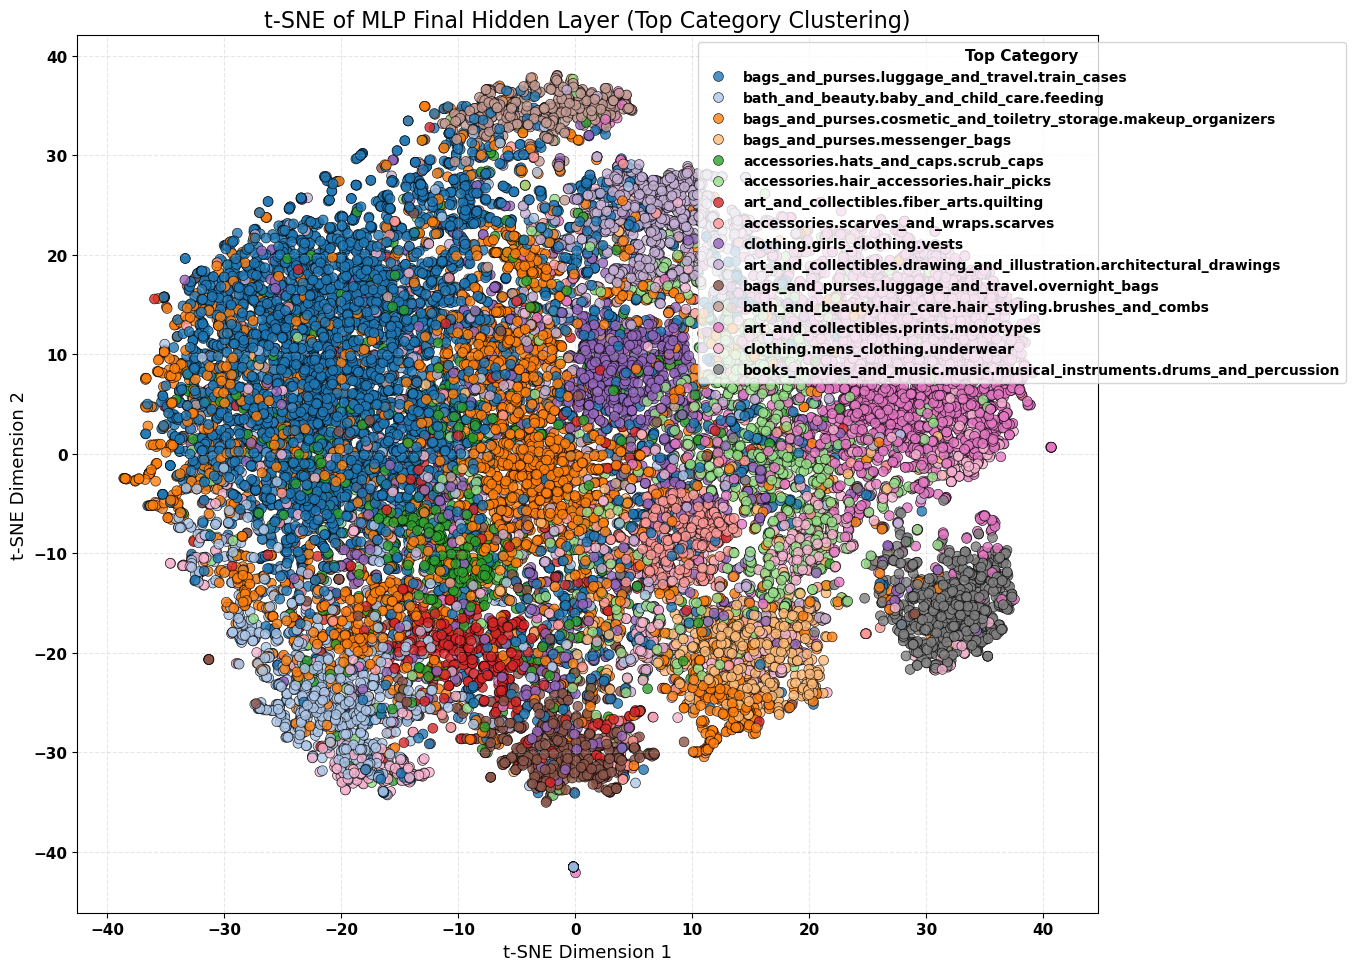

In [190]:

def get_last_hidden_layer_output(model, X):
    hidden_layer_sizes = model.hidden_layer_sizes
    if isinstance(hidden_layer_sizes, int):
        hidden_layer_sizes = [hidden_layer_sizes]
    weights = model.coefs_
    biases = model.intercepts_

    layer_input = X
    for i in range(len(hidden_layer_sizes)):
        layer_output = np.dot(layer_input, weights[i]) + biases[i]
        layer_output = np.maximum(0, layer_output)  
        layer_input = layer_output
    return layer_input  

hidden_outputs = get_last_hidden_layer_output(mlp_embed, X_val_embed)


tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
X_2d = tsne.fit_transform(hidden_outputs)

y_val_labels = label_encoder.inverse_transform(y_val)


df_plot = pd.DataFrame({
    "x": X_2d[:, 0],
    "y": X_2d[:, 1],
    "category": y_val_labels
})


plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=df_plot,
    x="x",
    y="y",
    hue="category",
    palette="tab20",
    s=50,
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5
)

plt.title("t-SNE of MLP Final Hidden Layer (Top Category Clustering)", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=13)
plt.ylabel("t-SNE Dimension 2", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1), title="Top Category", fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.savefig("/Users/sandyajaleshkumar/Desktop/top.png")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()



### Bottom Category

Batches:   0%|          | 0/136 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


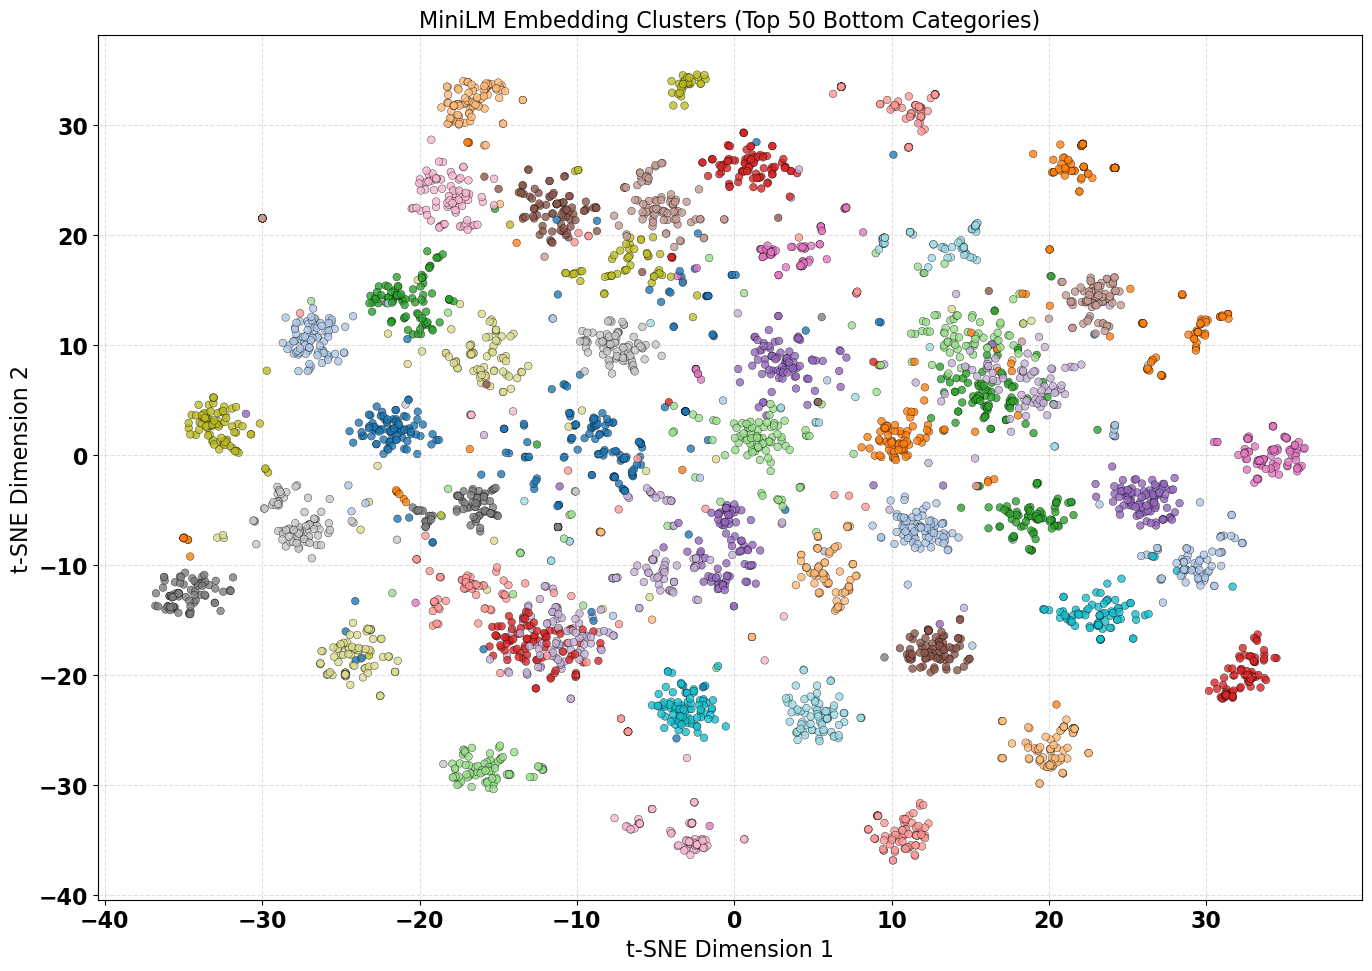

In [177]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns


top_50_bottom = df_training["bottom_category_text"].value_counts().head(50).index
filtered_df = df_training[df_training["bottom_category_text"].isin(top_50_bottom)]


def clean_text(text):
    if pd.isna(text): return ""
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

sample_text = (filtered_df["title"].fillna("") + " " +
               filtered_df["description"].fillna("") + " " +
               filtered_df["tags"].fillna("")).apply(clean_text)


embedder = SentenceTransformer("all-MiniLM-L6-v2")
X_embed = embedder.encode(sample_text.tolist(), normalize_embeddings=True, show_progress_bar=True)


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(filtered_df["bottom_category_text"])


tsne = TSNE(n_components=2, perplexity=40, random_state=42, n_iter=500)
X_proj = tsne.fit_transform(X_embed)


df_plot = pd.DataFrame({
    "x": X_proj[:, 0],
    "y": X_proj[:, 1],
    "label": y_encoded
})
df_plot["category"] = label_encoder.inverse_transform(df_plot["label"])

# Step 7: Plot
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=df_plot,
    x="x",
    y="y",
    hue="category",
    palette="tab20",
    s=30,
    alpha=0.8,
    edgecolor="black",
    linewidth=0.3,
    legend=False  
)
plt.title("MiniLM Embedding Clusters (Top 50 Bottom Categories)", fontsize=16)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
plt.savefig("/Users/sandyajaleshkumar/Desktop/bottom.png", dpi=300)

Batches:   0%|          | 0/136 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


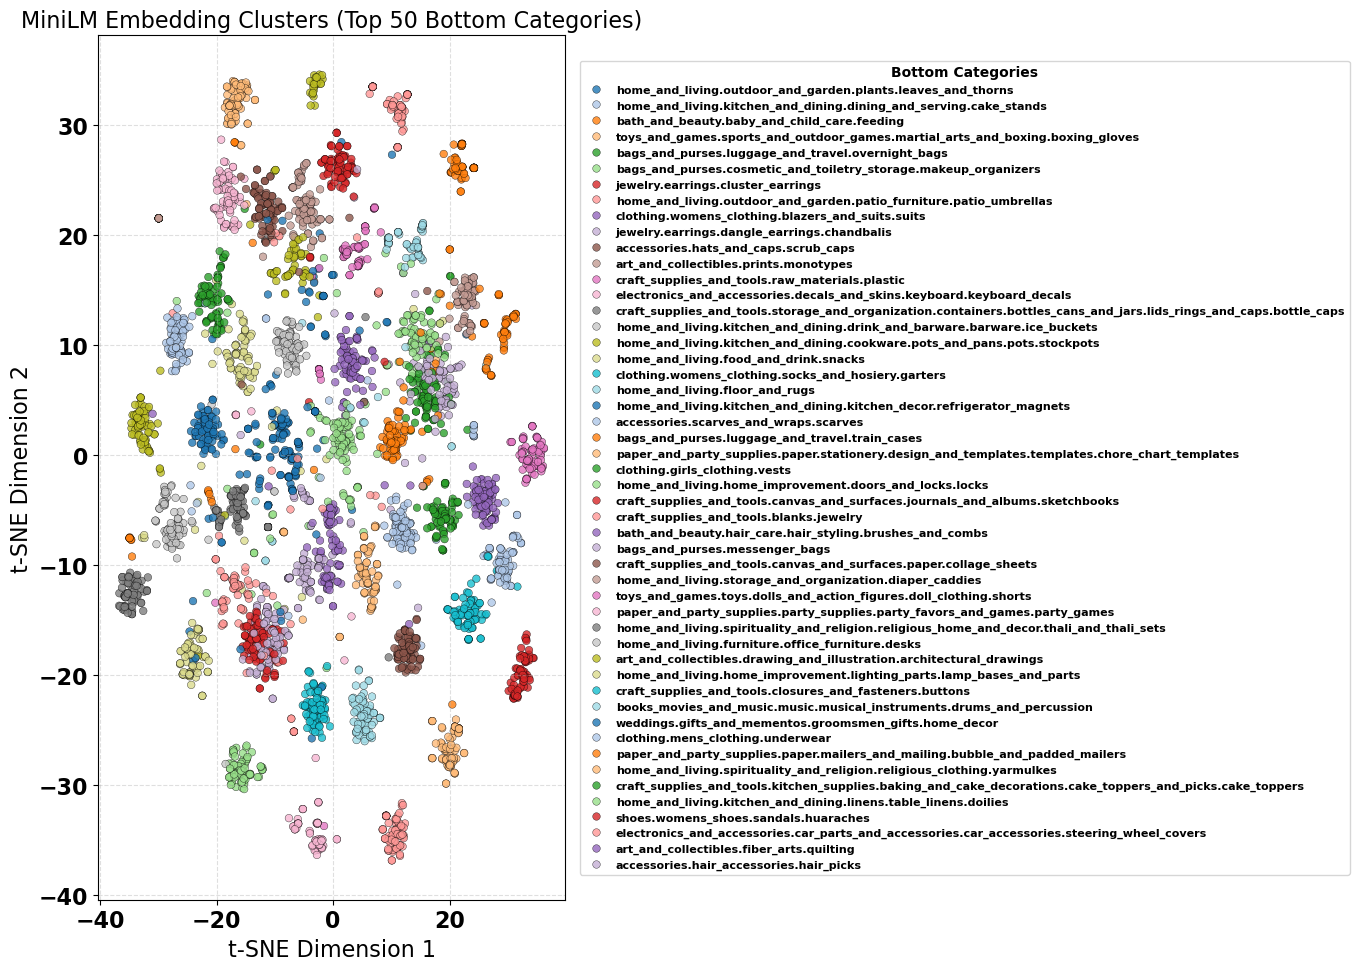

In [179]:

top_50_bottom = df_training["bottom_category_text"].value_counts().head(50).index
filtered_df = df_training[df_training["bottom_category_text"].isin(top_50_bottom)]

def clean_text(text):
    if pd.isna(text): return ""
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

sample_text = (filtered_df["title"].fillna("") + " " +
               filtered_df["description"].fillna("") + " " +
               filtered_df["tags"].fillna("")).apply(clean_text)


embedder = SentenceTransformer("all-MiniLM-L6-v2")
X_embed = embedder.encode(sample_text.tolist(), normalize_embeddings=True, show_progress_bar=True)


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(filtered_df["bottom_category_text"])


tsne = TSNE(n_components=2, perplexity=40, random_state=42, n_iter=500)
X_proj = tsne.fit_transform(X_embed)

df_plot = pd.DataFrame({
    "x": X_proj[:, 0],
    "y": X_proj[:, 1],
    "label": y_encoded
})
df_plot["category"] = label_encoder.inverse_transform(df_plot["label"])

plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=df_plot,
    x="x",
    y="y",
    hue="category",
    palette="tab20",
    s=30,
    alpha=0.8,
    edgecolor="black",
    linewidth=0.3,
    legend='full'
)
plt.title("MiniLM Embedding Clusters (Top 50 Bottom Categories)", fontsize=16)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), title="Bottom Categories", fontsize=8, title_fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
plt.savefig("/Users/sandyajaleshkumar/Desktop/bottom2.png", dpi=300)

Batches:   0%|          | 0/136 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✅ Image saved to: /Users/sandyajaleshkumar/Desktop/bottom_category_tsne.png


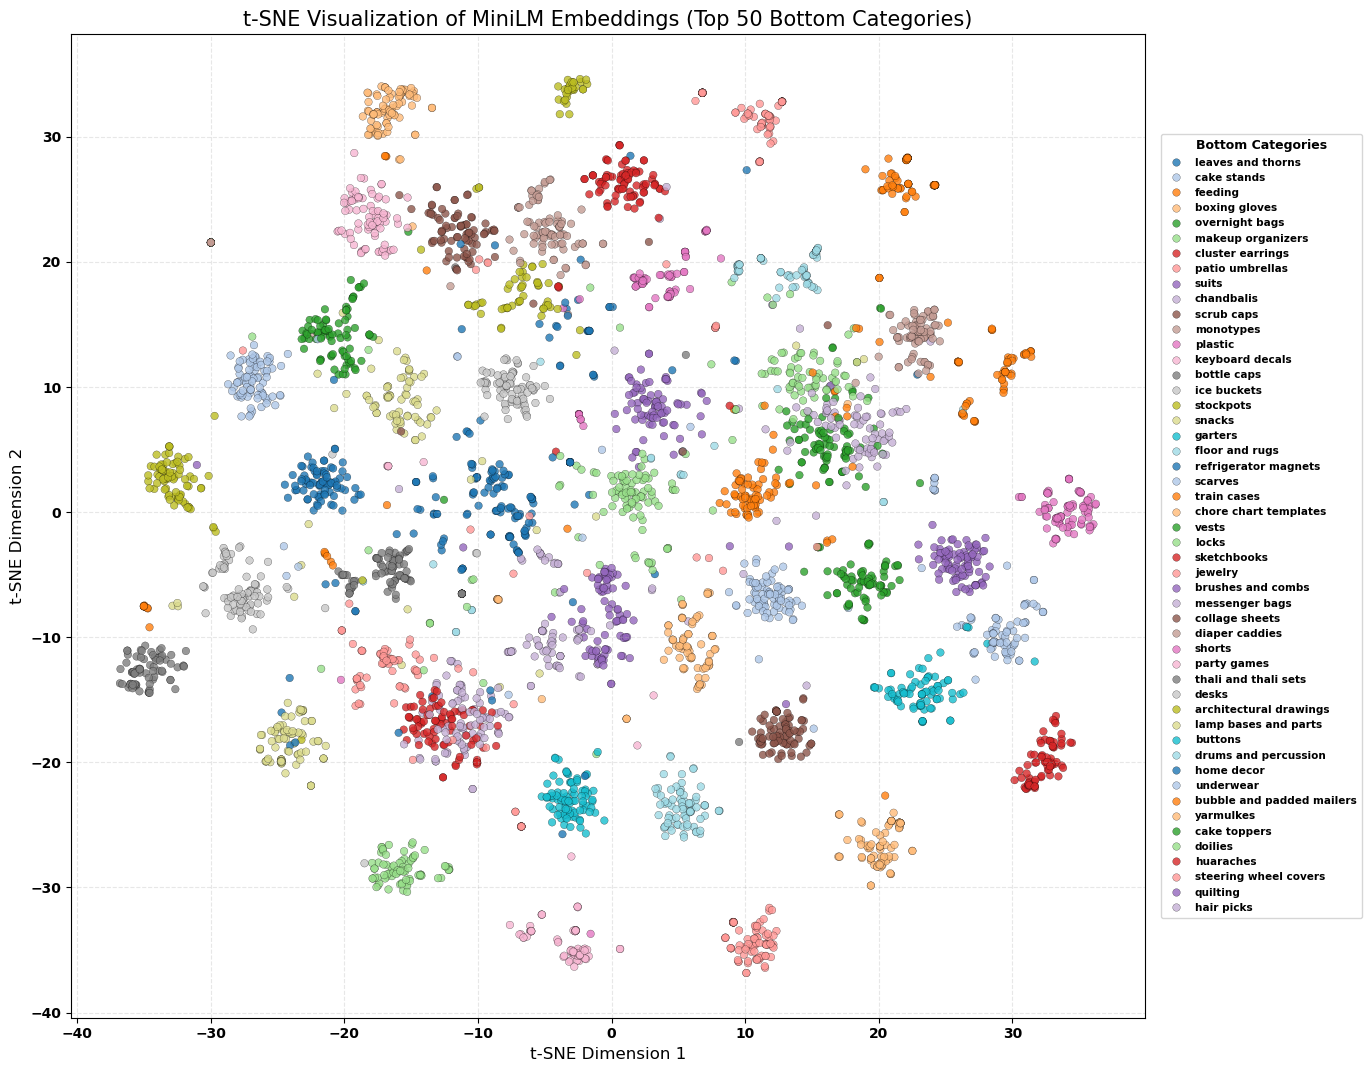

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
import os

# --- Step 1: Preprocess and Filter Top 50 Bottom Categories ---
top_50_bottom = df_training["bottom_category_text"].value_counts().head(50).index
filtered_df = df_training[df_training["bottom_category_text"].isin(top_50_bottom)]

def clean_text(text):
    if pd.isna(text): return ""
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

sample_text = (
    filtered_df["title"].fillna("") + " " +
    filtered_df["description"].fillna("") + " " +
    filtered_df["tags"].fillna("")
).apply(clean_text)

# --- Step 2: Generate MiniLM Embeddings ---
embedder = SentenceTransformer("all-MiniLM-L6-v2")
X_embed = embedder.encode(sample_text.tolist(), normalize_embeddings=True, show_progress_bar=True)

# --- Step 3: Encode Labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(filtered_df["bottom_category_text"])
categories = label_encoder.inverse_transform(np.unique(y_encoded))

# --- Step 4: Shorten Category Labels (Optional for Visualization) ---
def shorten(name):
    parts = name.split(".")
    return parts[-1].replace("_", " ")[:25]  # Show last token, shorten if needed

short_labels = [shorten(cat) for cat in categories]
category_map = dict(zip(categories, short_labels))

# --- Step 5: Run t-SNE ---
tsne = TSNE(n_components=2, perplexity=40, random_state=42, n_iter=500)
X_proj = tsne.fit_transform(X_embed)

# --- Step 6: Prepare DataFrame for Plot ---
df_plot = pd.DataFrame({
    "x": X_proj[:, 0],
    "y": X_proj[:, 1],
    "label": y_encoded
})
df_plot["category"] = label_encoder.inverse_transform(df_plot["label"])
df_plot["category_short"] = df_plot["category"].map(category_map)

# --- Step 7: Plot ---
plt.figure(figsize=(14, 11))
sns.scatterplot(
    data=df_plot,
    x="x",
    y="y",
    hue="category_short",
    palette="tab20",
    s=30,
    alpha=0.8,
    edgecolor="black",
    linewidth=0.2,
    legend='full'
)

plt.title("t-SNE Visualization of MiniLM Embeddings (Top 50 Bottom Categories)", fontsize=15)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(
    loc="center left",
    bbox_to_anchor=(1.01, 0.5),
    title="Bottom Categories",
    fontsize=7.5,
    title_fontsize=9,
    frameon=True,
    borderpad=0.5
)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

# --- Step 8: Save the Image ---
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
file_path = os.path.join(desktop_path, "bottom_category_tsne.png")
plt.savefig(file_path, dpi=300)
print(f"✅ Image saved to: {file_path}")

plt.show()


### Training - GIVEN


As a simple example, let's follow the [Working With Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) tutorial from scikit-learn that:

- processes the text using `CountVectorizer`, that builds a dictionary of features and transforms documents to feature vectors
- extracts term frequencies and inverse document frequencies using `TfidfTransformer`, (see [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))
- trains a naïve Bayes classifier, which gives us a nice baseline

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [ ]:
train_text = df_training['title'].fillna('').values

In [ ]:
train_labels = df_training['top_category_text'].values

In [ ]:
text_clf.fit(train_text, train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

### Evaluation

Using our validation dataset, compute a number of metrics to measure how well we generalize on our validation set.

In [ ]:
val_text = df_validation['title'].fillna('').values
val_labels = df_validation['top_category_text'].values

In [ ]:
index = 0
print(f"""
Product's title: {val_text[index][:80]}...
Prediction: '{text_clf.predict([val_text[index]])[0]}', Groundtruth: '{val_labels[index]}'
""".strip())

Product's title: Vintage enamel funnel - White metal funnel with handle - Large rusty funnel - Ki...
Prediction: 'home_and_living', Groundtruth: 'home_and_living'


In [ ]:
df_validation.iloc[0]

product_id                                                     1085759015
title                   Vintage enamel funnel - White metal funnel wit...
description             Vintage enamel funnel - White metal funnel wit...
tags                    Enamel Funnel,Vintage metal funnel,Enamelware ...
type                                                             physical
room                                                                     
craft_type                                                     winemaking
recipient                                                                
material                                                                 
occasion                                                                 
holiday                                                                  
art_subject                                                              
style                                                                    
shape                                 

In [ ]:
val_text[:1]

array(['Vintage enamel funnel - White metal funnel with handle - Large rusty funnel - Kitchen pouring tool - Bulgarian enamelware - Old shabby chic'],
      dtype=object)

In [ ]:
predictions = text_clf.predict(val_text)

In [ ]:
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [ ]:
f"F1 score: {f1:.4f}"

'F1 score: 0.6392'

In [ ]:
print(metrics.classification_report(val_labels, predictions))

                             precision    recall  f1-score   support

                accessories       0.84      0.41      0.55      1243
       art_and_collectibles       0.86      0.09      0.16       870
            bags_and_purses       0.93      0.29      0.45       664
            bath_and_beauty       0.94      0.46      0.62      1140
     books_movies_and_music       0.98      0.31      0.47       626
                   clothing       0.73      0.96      0.83      3004
   craft_supplies_and_tools       0.62      0.77      0.69      3337
electronics_and_accessories       0.96      0.49      0.65       747
            home_and_living       0.54      0.96      0.69      5460
                    jewelry       0.91      0.37      0.53       782
   paper_and_party_supplies       0.80      0.58      0.67      1223
               pet_supplies       0.93      0.28      0.43       574
                      shoes       0.95      0.73      0.83       891
             toys_and_games      

In [ ]:
metrics.confusion_matrix(val_labels, predictions)

array([[ 507,    0,    1,    4,    0,  269,  155,    0,  250,    2,    4,
           2,    2,    7,   40],
       [   5,   78,    0,    0,    0,   31,  137,    2,  593,    0,    7,
           1,    0,   12,    4],
       [   2,    0,  195,   11,    0,   44,  114,    1,  279,    0,    5,
           1,    1,    6,    5],
       [  11,    0,    4,  528,    0,   68,  129,    1,  383,    4,    3,
           1,    1,    6,    1],
       [   1,    3,    0,    0,  193,   12,   90,    4,  298,    0,   17,
           3,    0,    4,    1],
       [   7,    0,    0,    2,    1, 2894,   15,    0,   72,    1,    5,
           0,    2,    0,    5],
       [   5,    4,    0,    3,    0,   35, 2576,    1,  676,    2,   21,
           0,    4,    6,    4],
       [   1,    0,    3,    0,    1,   14,   87,  365,  259,    0,    5,
           1,    0,   11,    0],
       [   1,    4,    2,    5,    0,   44,  123,    3, 5235,    0,   27,
           2,    0,   11,    3],
       [  16,    0,    0,    2,    1,

**Note** that this is just a baseline that uses a naïve Bayes classifier and uses the `title` only as inputs, there are many more parameters that can be used in addition to multiple architectures and processing approaches

## Submission

Prepare a submission for the test data. Here I am using some dummy values, all zeros, as the ids for top categories, bottom categories, primary colors and secondary colors. Feed-forward the test data through your model, get the predictions per product and output them onto a file to be checked against the true values.

Happy Hacking!

In [ ]:
df_predictions = df_test.copy()

In [ ]:
# dummy values
df_predictions["top_category_id"] = np.zeros(len(df_test), dtype=int)
df_predictions["bottom_category_id"] = np.zeros(len(df_test), dtype=int)

In [ ]:
student_id = "12345689"
df_predictions[
    ["product_id", "top_category_id", "bottom_category_id"]
].to_parquet(f"predictions_{student_id}.parquet")

In [206]:
base_path = "/Users/sandyajaleshkumar/Desktop/Machine Learning/Assignment/Predictions"

top_df = pd.read_csv(f"{base_path}/top_category_predictions.csv")
bottom_df = pd.read_csv(f"{base_path}/bottom_category_predictions.csv")

top_df.rename(columns={"predicted_top_category_id": "top_category_id"}, inplace=True)
bottom_df.rename(columns={"predicted_bottom_category_id": "bottom_category_id"}, inplace=True)


df_predictions = pd.merge(top_df, bottom_df, on="product_id")


student_id = "A00014392"  

output_path = f"{base_path}/predictions_{student_id}.parquet"
df_predictions[["product_id", "top_category_id", "bottom_category_id"]].to_parquet(output_path, index=False)

print("Submission saved to:", output_path)


Submission saved to: /Users/sandyajaleshkumar/Desktop/Machine Learning/Assignment/Predictions/predictions_A00014392.parquet
